# Current sheet statistics

In [0]:
using Dates
using StatsBase, Statistics
using PSPAnisotropy
import Discontinuity as DC
using Discontinuity: var_mapping, compute_params!, filter_low_mva_quality
using Discontinuity: compute_Alfvenicity_params!, Alfven_velocity
using DimensionalData
using DataFrames, DataFramesMeta
using CairoMakie
using Beforerr: _theme_legend, easy_save, hide_facet_labels!, add_labels!
using Beforerr
using CategoricalArrays
using AlgebraOfGraphics
using AlgebraOfGraphics: data
import AlgebraOfGraphics as AoG
using LinearAlgebra
using Accessors
using Unitful
Unitful.preferunits(u"nA", u"km")

includet("../src/plot.jl")

# https://github.com/MakieOrg/AlgebraOfGraphics.jl/issues/464
# foreach([:log10, :log2, :log]) do f
# @eval import Base: $f
# @eval $f(x::Unitful.Quantity) = $f(ustrip(x))
# end
set_Z_theme!()

In [0]:
𝐧 = :mva
𝒎 = var_mapping(; 𝐧)

taus = Second.(2 .^ (1:6))
# taus = Second.(2 .^ (0:6))
wdf = workload(taus)

_float64(x) = passmissing(Float64)(x)

A_lens = @optic _.model.A

df = @chain wdf begin
    DC.compute_Alfvenicity_params!()
    DC.compute_params!()
    @transform @astable begin
        :Δ𝐁 = @. norm(:B_us - :B_ds)
        :Δ𝐁_fit = @. 2 * passmissing(A_lens)(:model) |> abs
        :Δ𝐁_norm = :Δ𝐁 ./ :B_mag
        :Δ𝐁_fit_norm = :Δ𝐁_fit ./ :B_mag
        :B_n_mva_norm = abs.(:B_n_mva ./ :B_mag)
        :duration = _float64.(ustrip.(:duration .|> u"s"))
        :L_n_mva = _float64.(ustrip.(:L_n_mva))
        :J_m_max_mva = _float64.(ustrip.(:J_m_max_mva))
        :L_n_cross = _float64.(ustrip.(:L_n_cross))
        :J_m_max_cross = _float64.(ustrip.(:J_m_max_cross))
    end
    DC.classify!(:B_n_mva_norm)
end

# Count the number of events for each type
df_event_counts = @chain df begin
    groupby(:type)
    combine(nrow)
end

thm_df = @rsubset(df, :id == "THEMIS"; view=true)
thm_df.id .= "ARTEMIS"
df.id = categorical(df.id)
levels!(df.id, ["PSP", "ARTEMIS", "Wind"])

subset_𝐧(df, 𝐧) = 𝐧 == :mva ? filter_low_mva_quality(df) : df
const datalimits = x -> quantile(x, [0.01, 0.99])

## Associations and independence test

In [0]:

println("\n" * "="^60)
println("ASSOCIATION ANALYSIS FOR ALFVÉNICITY")
println("="^60)

# Define the variable pairs you want to analyze with transformations embedded
alfvenicity_pairs = [
    (:duration, :Q_sonnerup => abs, "Duration vs Alfvénicity (Q_sonnerup)"),
    (:duration, :V_l_ratio, "Duration vs Velocity Ratio (V_l_ratio)"),
    (:B_n_mva_norm, :Q_sonnerup => abs, "Magnetic Field Normal vs Alfvénicity"),
    (:σ_c, :Q_sonnerup, "Cross helicity vs Alfvénicity"),
    (:σ_r, :Q_sonnerup),
    (:β, :Q_sonnerup => abs),
    (:A_He => x -> ismissing(x) ? missing : only(x), :Q_sonnerup => abs, "Helium Abundance vs Alfvénicity"),
    (:J_m_max_mva_norm, :Q_sonnerup => abs, "Current density vs Alfvénicity"),
    (:L_n_mva_norm, :Q_sonnerup => abs, "Thickness vs Alfvénicity"),
    (:A_He => x -> ismissing(x) ? missing : only(x), :J_m_max_mva_norm),
    (:A_He => x -> ismissing(x) ? missing : only(x), :L_n_mva_norm),
    (:β, :J_m_max_mva_norm),
    (:β, :L_n_mva_norm),
    (:β, :A_He),
]

# Run overall analysis
println("OVERALL ASSOCIATION ANALYSIS")
println("="^50)
analyze_associations(df, alfvenicity_pairs)

# Grouped analysis
# println("GROUPED ASSOCIATION ANALYSIS (by $(group_by))")
println("="^50)
analyze_associations(df, alfvenicity_pairs; group_by=:id)

``` md
Association Measure Interpretation:
Values range from 0 (no association) to 1 (perfect association):
- 0.0 - 0.1: Very weak association
- 0.1 - 0.3: Weak association  
- 0.3 - 0.5: Moderate association
- 0.5 - 0.7: Strong association
- 0.7 - 1.0: Very strong association

Association Methods Used:
1. Distance Correlation: Non-parametric measure detecting linear & nonlinear dependencies
2. Pearson Correlation: Standard linear correlation coefficient  
3. Spearman Correlation: Rank-based correlation (monotonic relationships)
4. Chatterjee Correlation: New robust measure for general dependencies
5. Mutual Information: Information-theoretic measure of shared information

Note: These are association strengths, not statistical significance tests.
For independence testing, use with caution - consider both effect size and sample size.
```

[](../association_results.txt)

``` md

🔎 Step 1. General observations
    •   Cross helicity vs Alfvénicity absolutely dominates:
    •   Pearson = 0.84 overall (0.92 in PSP, 0.76 in Wind).
    •   Chatterjee = 0.47–0.53.
    •   MI = 0.58–0.97.
→ This is a very strong dependence by any metric, which is expected since Alfvénicity is conceptually related to cross helicity.
    •   Magnetic field normal vs Alfvénicity shows weak-to-moderate positive linear correlation (~0.17–0.19), but Chatterjee and MI stay low. Suggests a weak linear trend, not a strong monotonic or nonlinear relationship.
    •   Σ_r vs Q_sonnerup:
    •   Small negative Pearson (~ -0.1).
    •   But Chatterjee 0.09–0.15 and MI up to 0.24 in PSP → weak, possibly nonlinear dependence.
    •   This might indicate subtle structure missed by linear correlation.
    •   Duration, velocity ratio, thickness, helium abundance, current density:
    •   All show weak or negligible correlations (|Pearson| < 0.25, Chatterjee mostly < 0.06, MI close to 0).
    •   Suggests near independence, with only minor dataset-specific effects (e.g., PSP helium abundance at -0.24).

⸻

🔎 Step 2. Dataset comparison (PSP vs Wind)
    •   Cross helicity vs Alfvénicity is strong in both spacecraft, but even stronger in PSP (r ~ 0.92 vs 0.76).
    •   Magnetic field normal vs Alfvénicity is similar across PSP/Wind (r ~ 0.17–0.18).
    •   Σ_r vs Q_sonnerup is stronger in PSP (MI ~0.24 vs 0.05 in Wind).
    •   Helium abundance vs Alfvénicity:
    •   PSP: moderate negative Pearson (-0.24).
    •   Wind: near zero.
→ Suggests PSP-specific dependence (possibly tied to solar wind composition closer to the Sun).
    •   The rest (duration, velocity ratio, thickness, current density) are consistently weak in both datasets.

⸻

🔎 Step 3. Practical interpretation
    1.  Cross helicity is the defining feature of Alfvénicity.
The high correlations confirm that your Alfvénicity measure (Q_sonnerup) essentially tracks cross helicity. This is expected, but the strength of correlation (0.8–0.9) validates consistency across datasets.
    2.  Other plasma/structural properties are only weakly linked.
Magnetic field orientation (normal) shows a weak positive association, but not much more.
    3.  Σ_r (residual energy measure?) has a modest but interesting nonlinear association with Alfvénicity, especially in PSP. Could hint at a subtle dependence worth exploring with scatter plots or conditional analysis.
    4.  Helium abundance only matters in PSP.
The -0.24 Pearson suggests Alfvénicity tends to be lower in He-rich regions, but this trend does not appear in Wind. That could reflect heliocentric distance effects.

⸻

✅ Summary of main findings:
    •   Strong dependence: Cross helicity ↔ Alfvénicity (core relationship).
    •   Weak but consistent: Magnetic field normal, Σ_r (especially in PSP).
    •   Dataset-specific: Helium abundance (negative in PSP, absent in Wind).
    •   Effectively independent: Duration, velocity ratio, thickness, current density.

⸻
```

Would you like me to help you visualize these dependencies (scatter plots, density plots, MI heatmaps) to confirm the weak vs strong associations, or do you just need a written interpretation for now?

## Thickness and current density

Density distributions of (normalized) thickness and current density

In [0]:
fname = "properties_hist"

update_theme!(;
    Legend=(; framevisible=false, padding=(0, 0, 0, 0)),
)

fs = map([:mva, :cross]) do 𝐧
    plot_properties_hist(df, 𝐧)
    # subset df by plasma beta
    # plot_properties_hist(@rsubset(df, :β < 1), 𝐧)
    # plot_properties_hist(@rsubset(df, :β > 3), 𝐧)
    easy_save("$fname-$𝐧"; force=true)
    # easy_save("$fname-$𝐧")
end
fs[1]

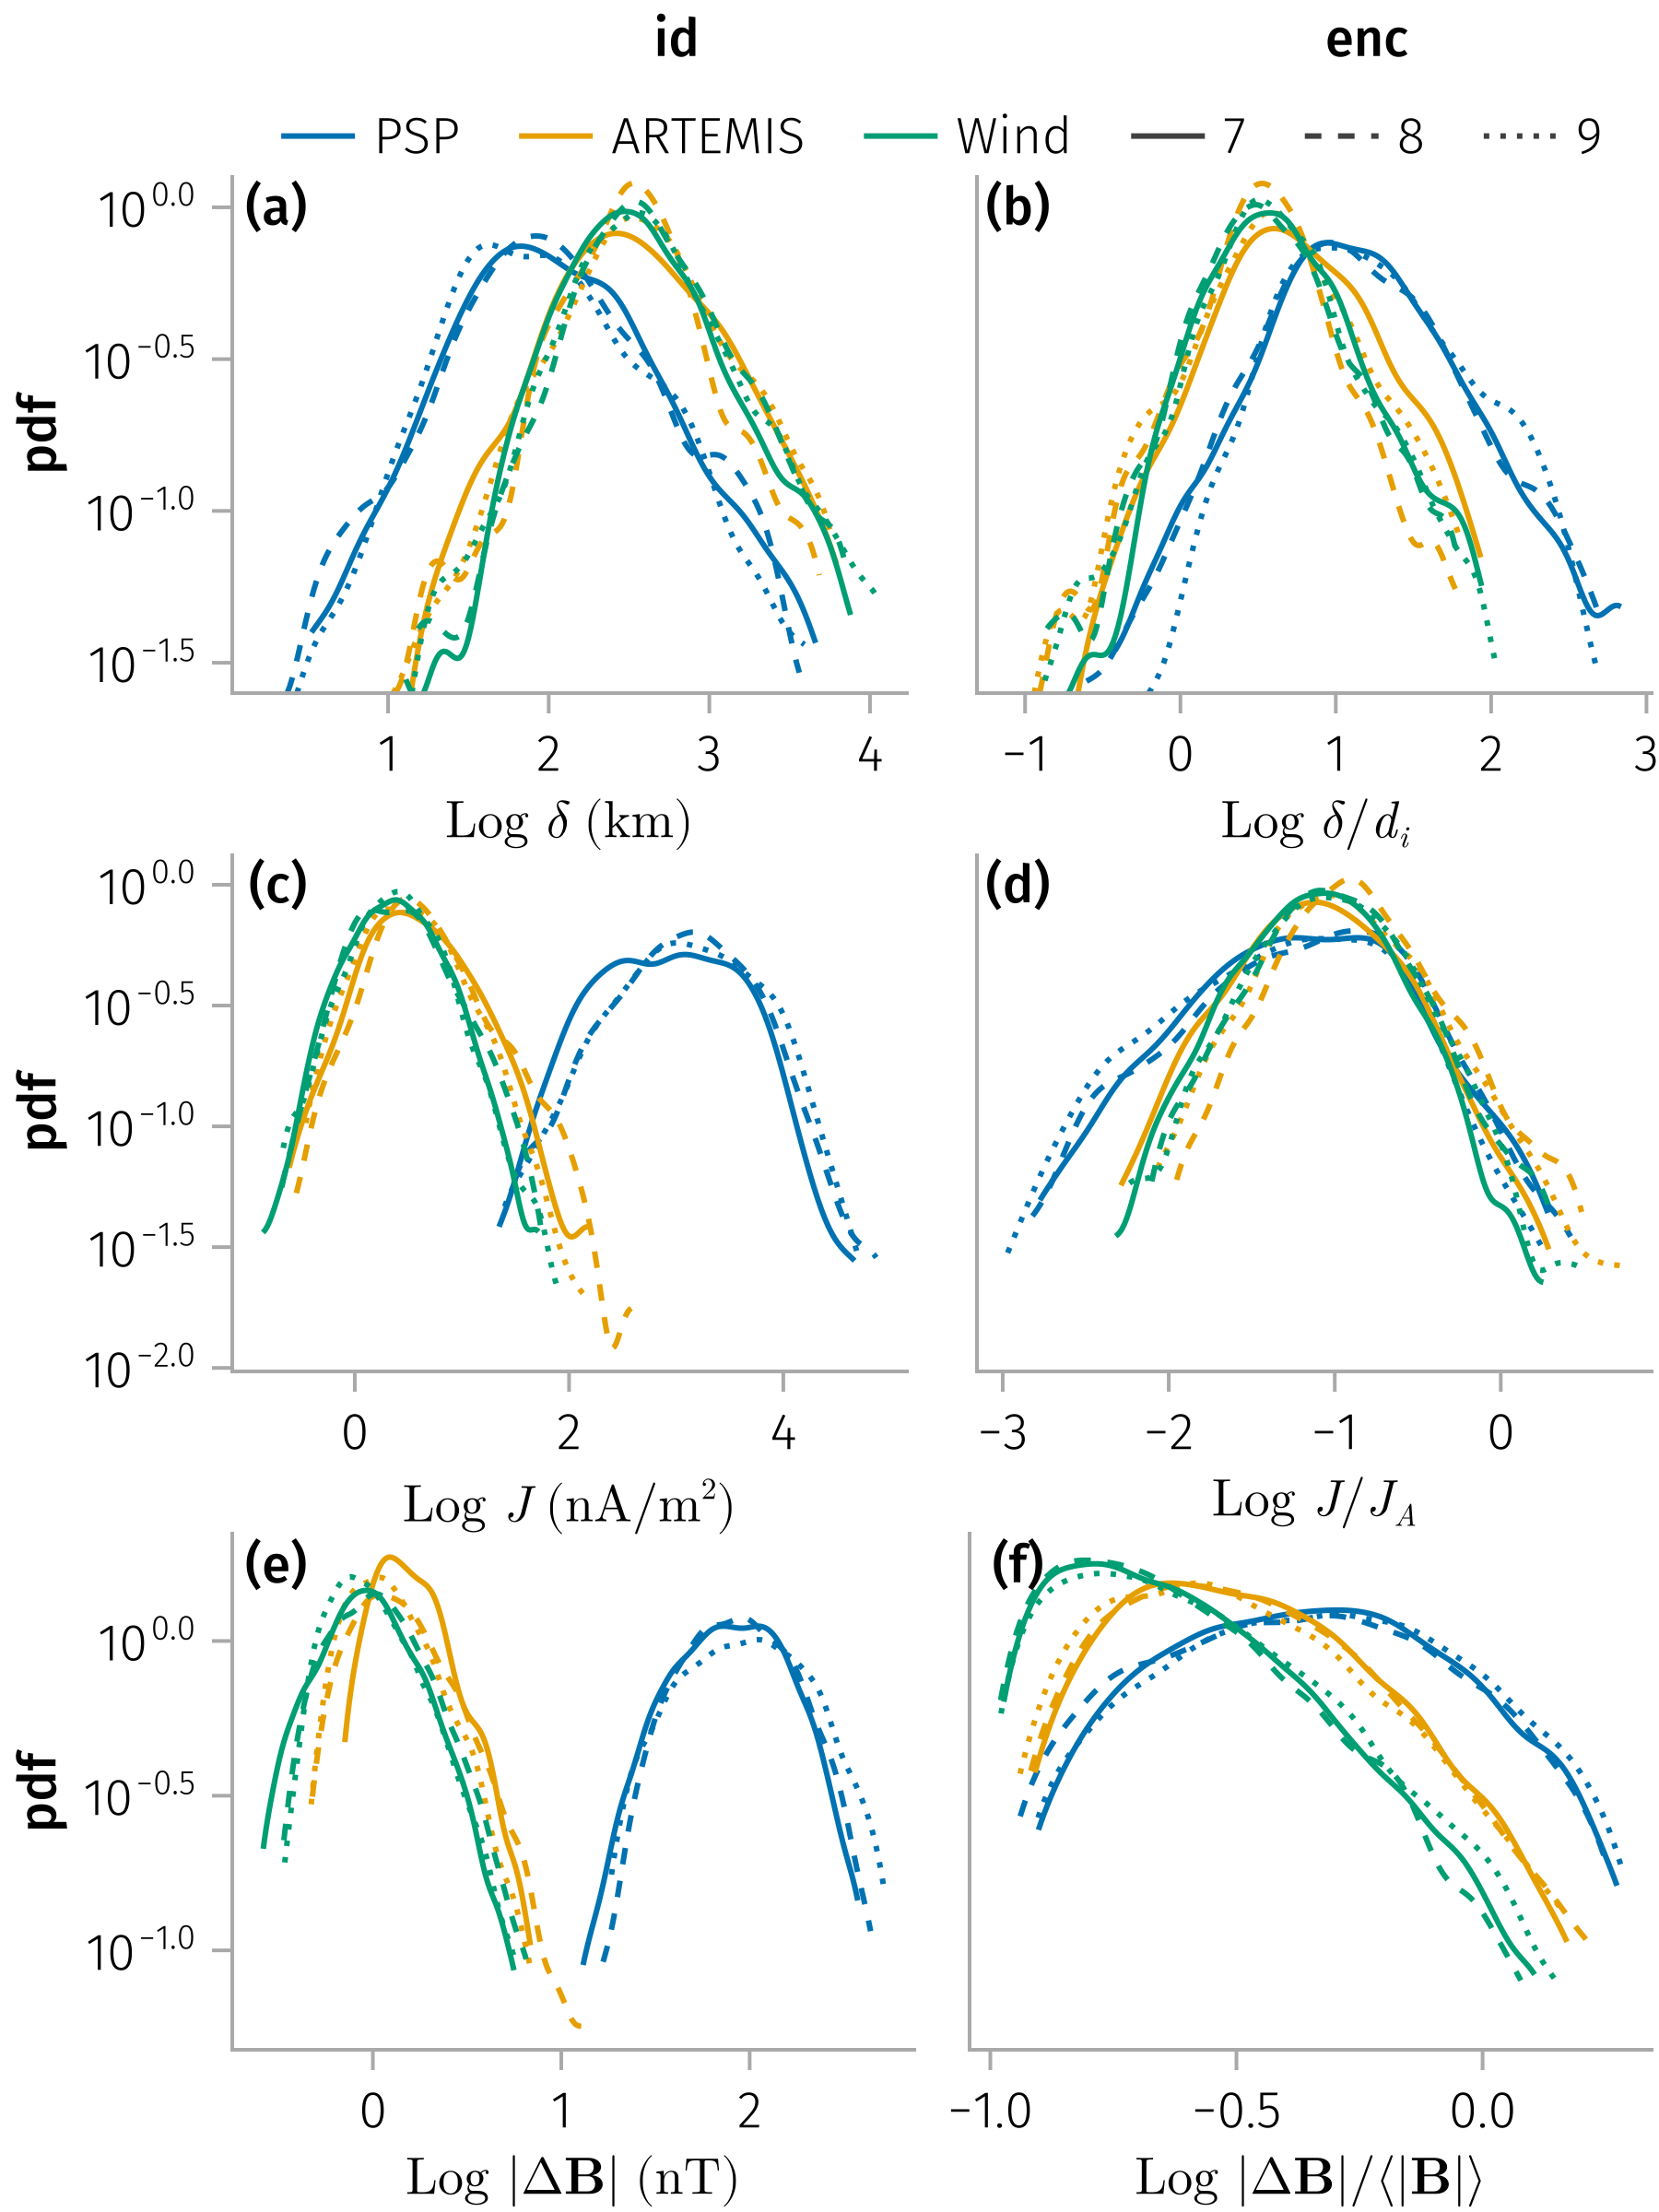
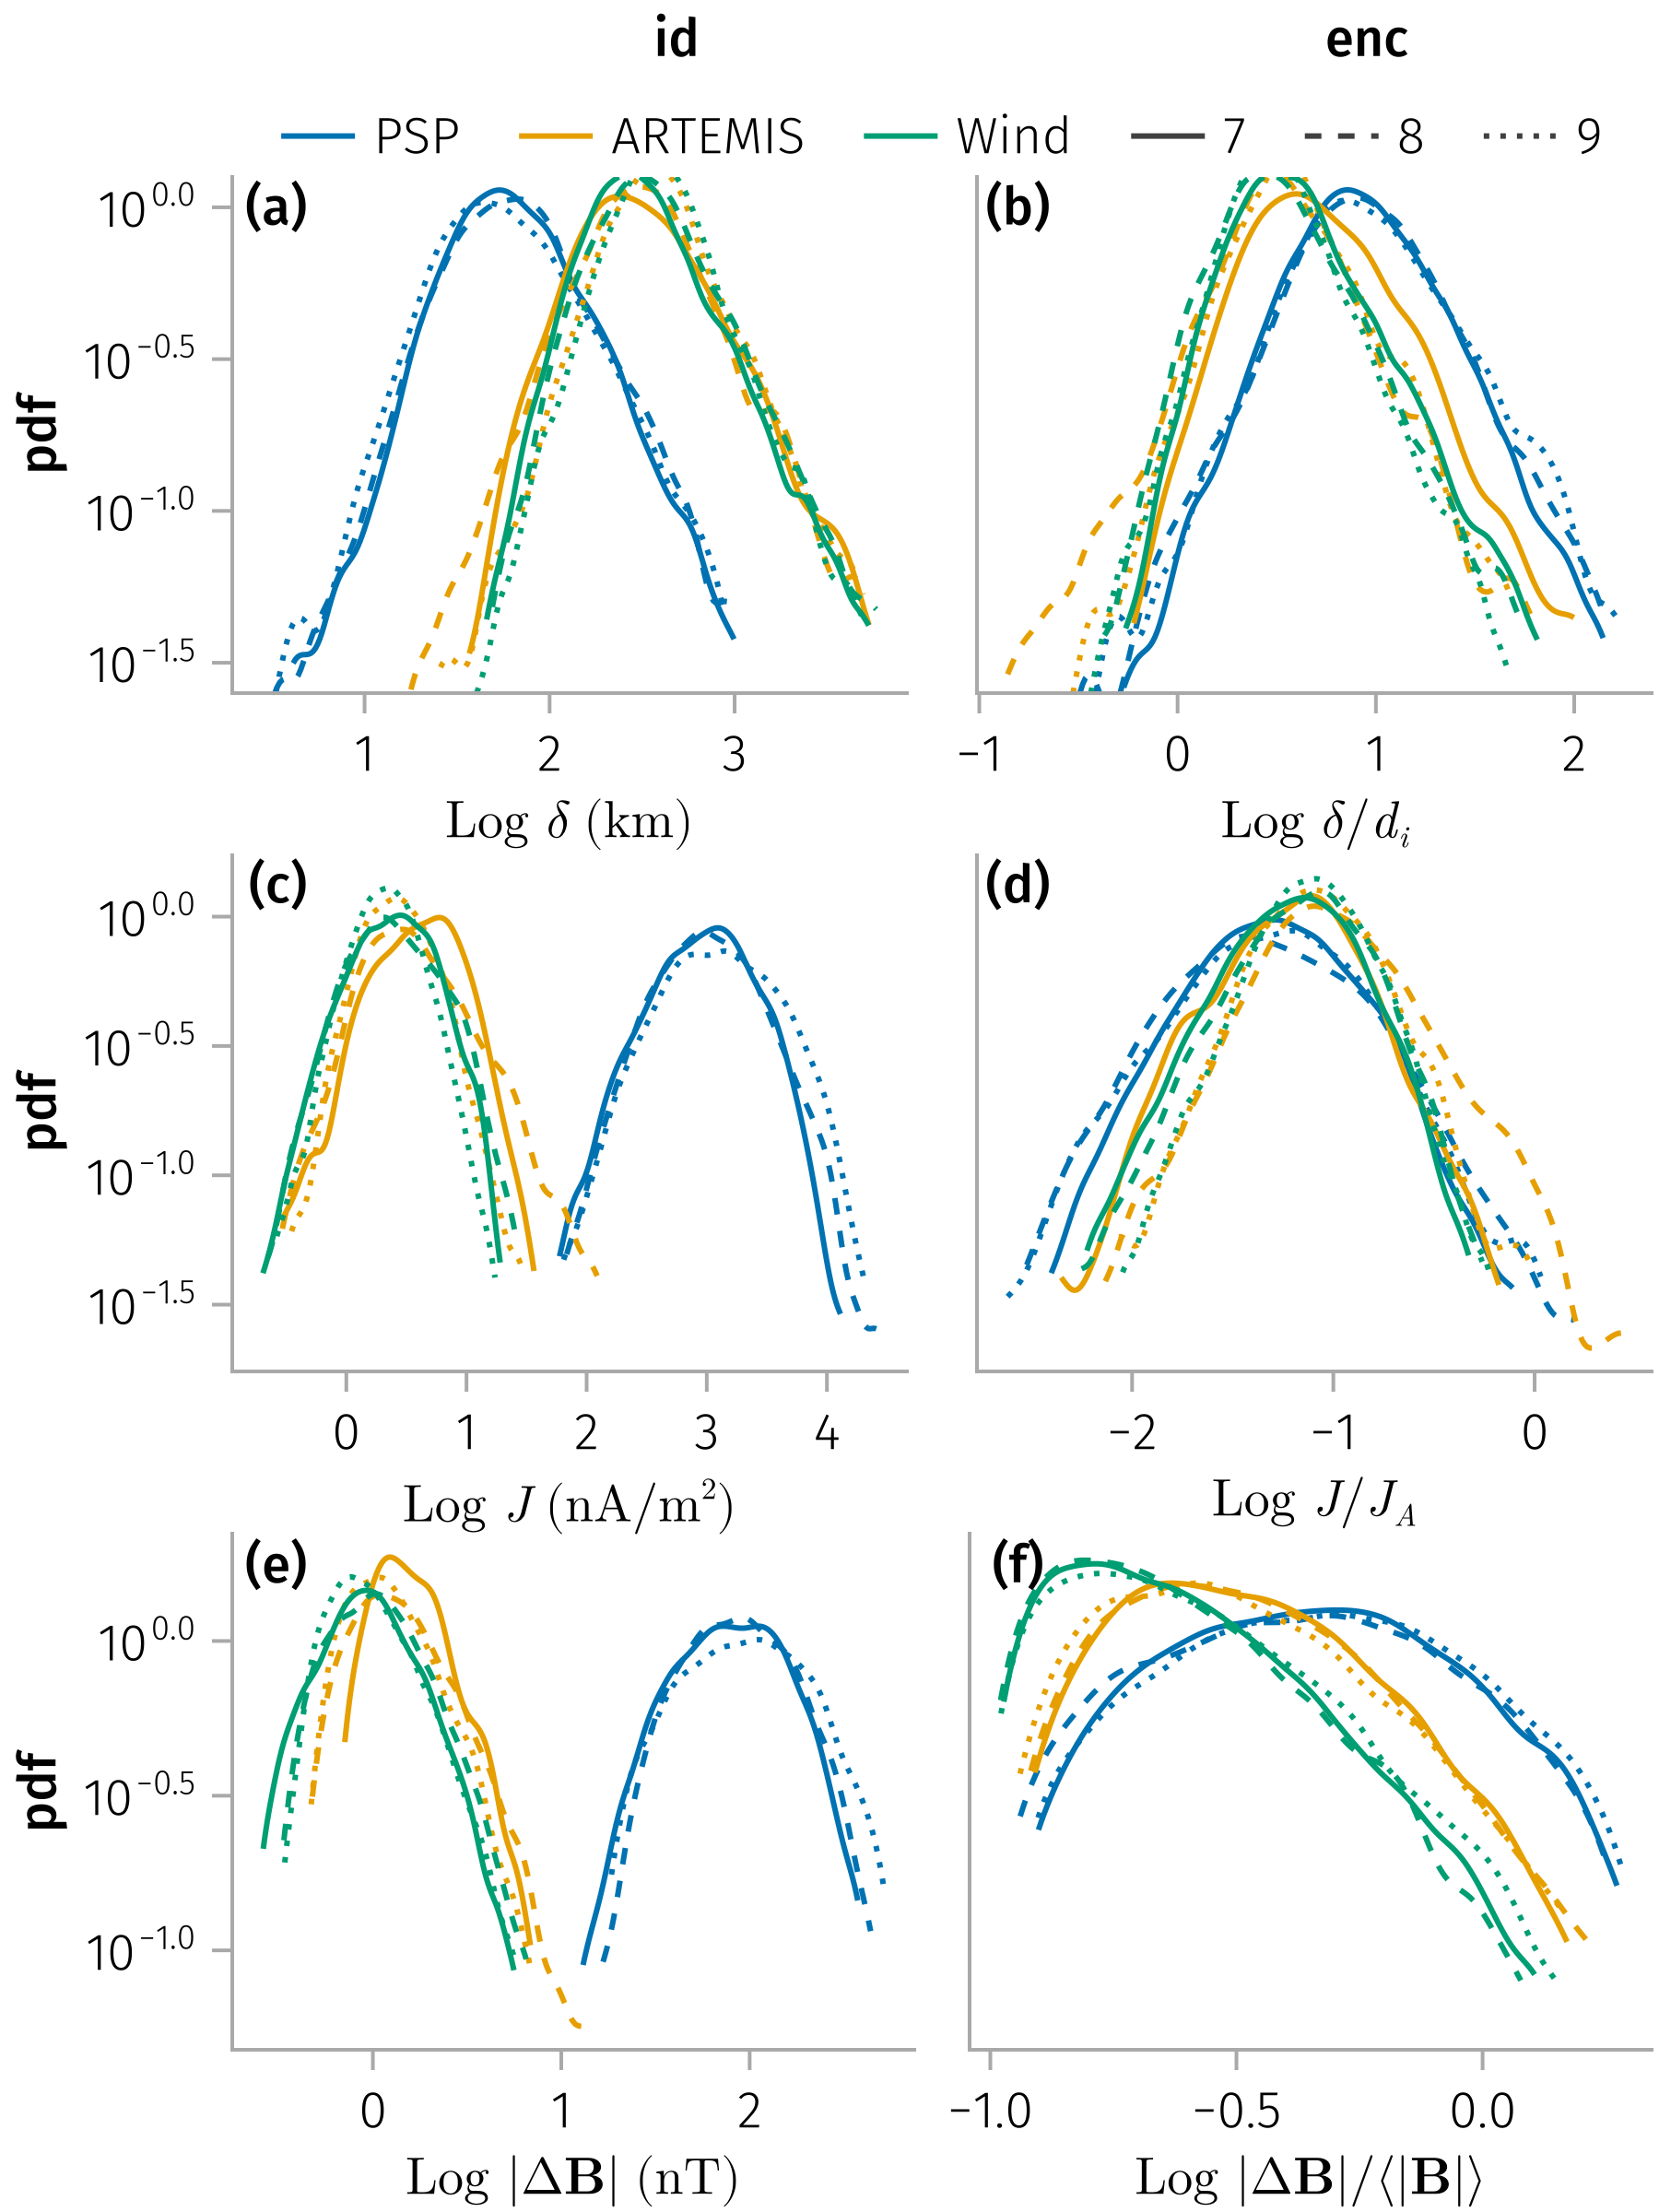

## Duration (temporal thickness)

Now we analyze what is the distribution of the duration of the current sheet, and how does it vary with the different tau we use.

Plot duration distributions for different missions and time periods.

In [0]:
let tdf = dropmissing(df, :duration)
    psp_df = @chain tdf begin
        @rsubset(:id == "PSP"; view=true)
        @transform(:duration = :duration .* 4, :id = "PSP (4x)")
    end
    fdf = vcat(tdf, psp_df)
    axis = (; yscale=log10)
    layer = mapping(:duration) * AoG.density(; datalimits=x -> quantile(x, [0.01, 0.99])) * visual(Lines)
    plt = data(fdf) * mapping(color=:id) * layer
    plt = plt + mapping(2 .^ (0:5)) * visual(VLines, color=:gray, linestyle=:dash)
    fg = draw(plt; axis)

    easy_save("duration_dist"; force=true)
end

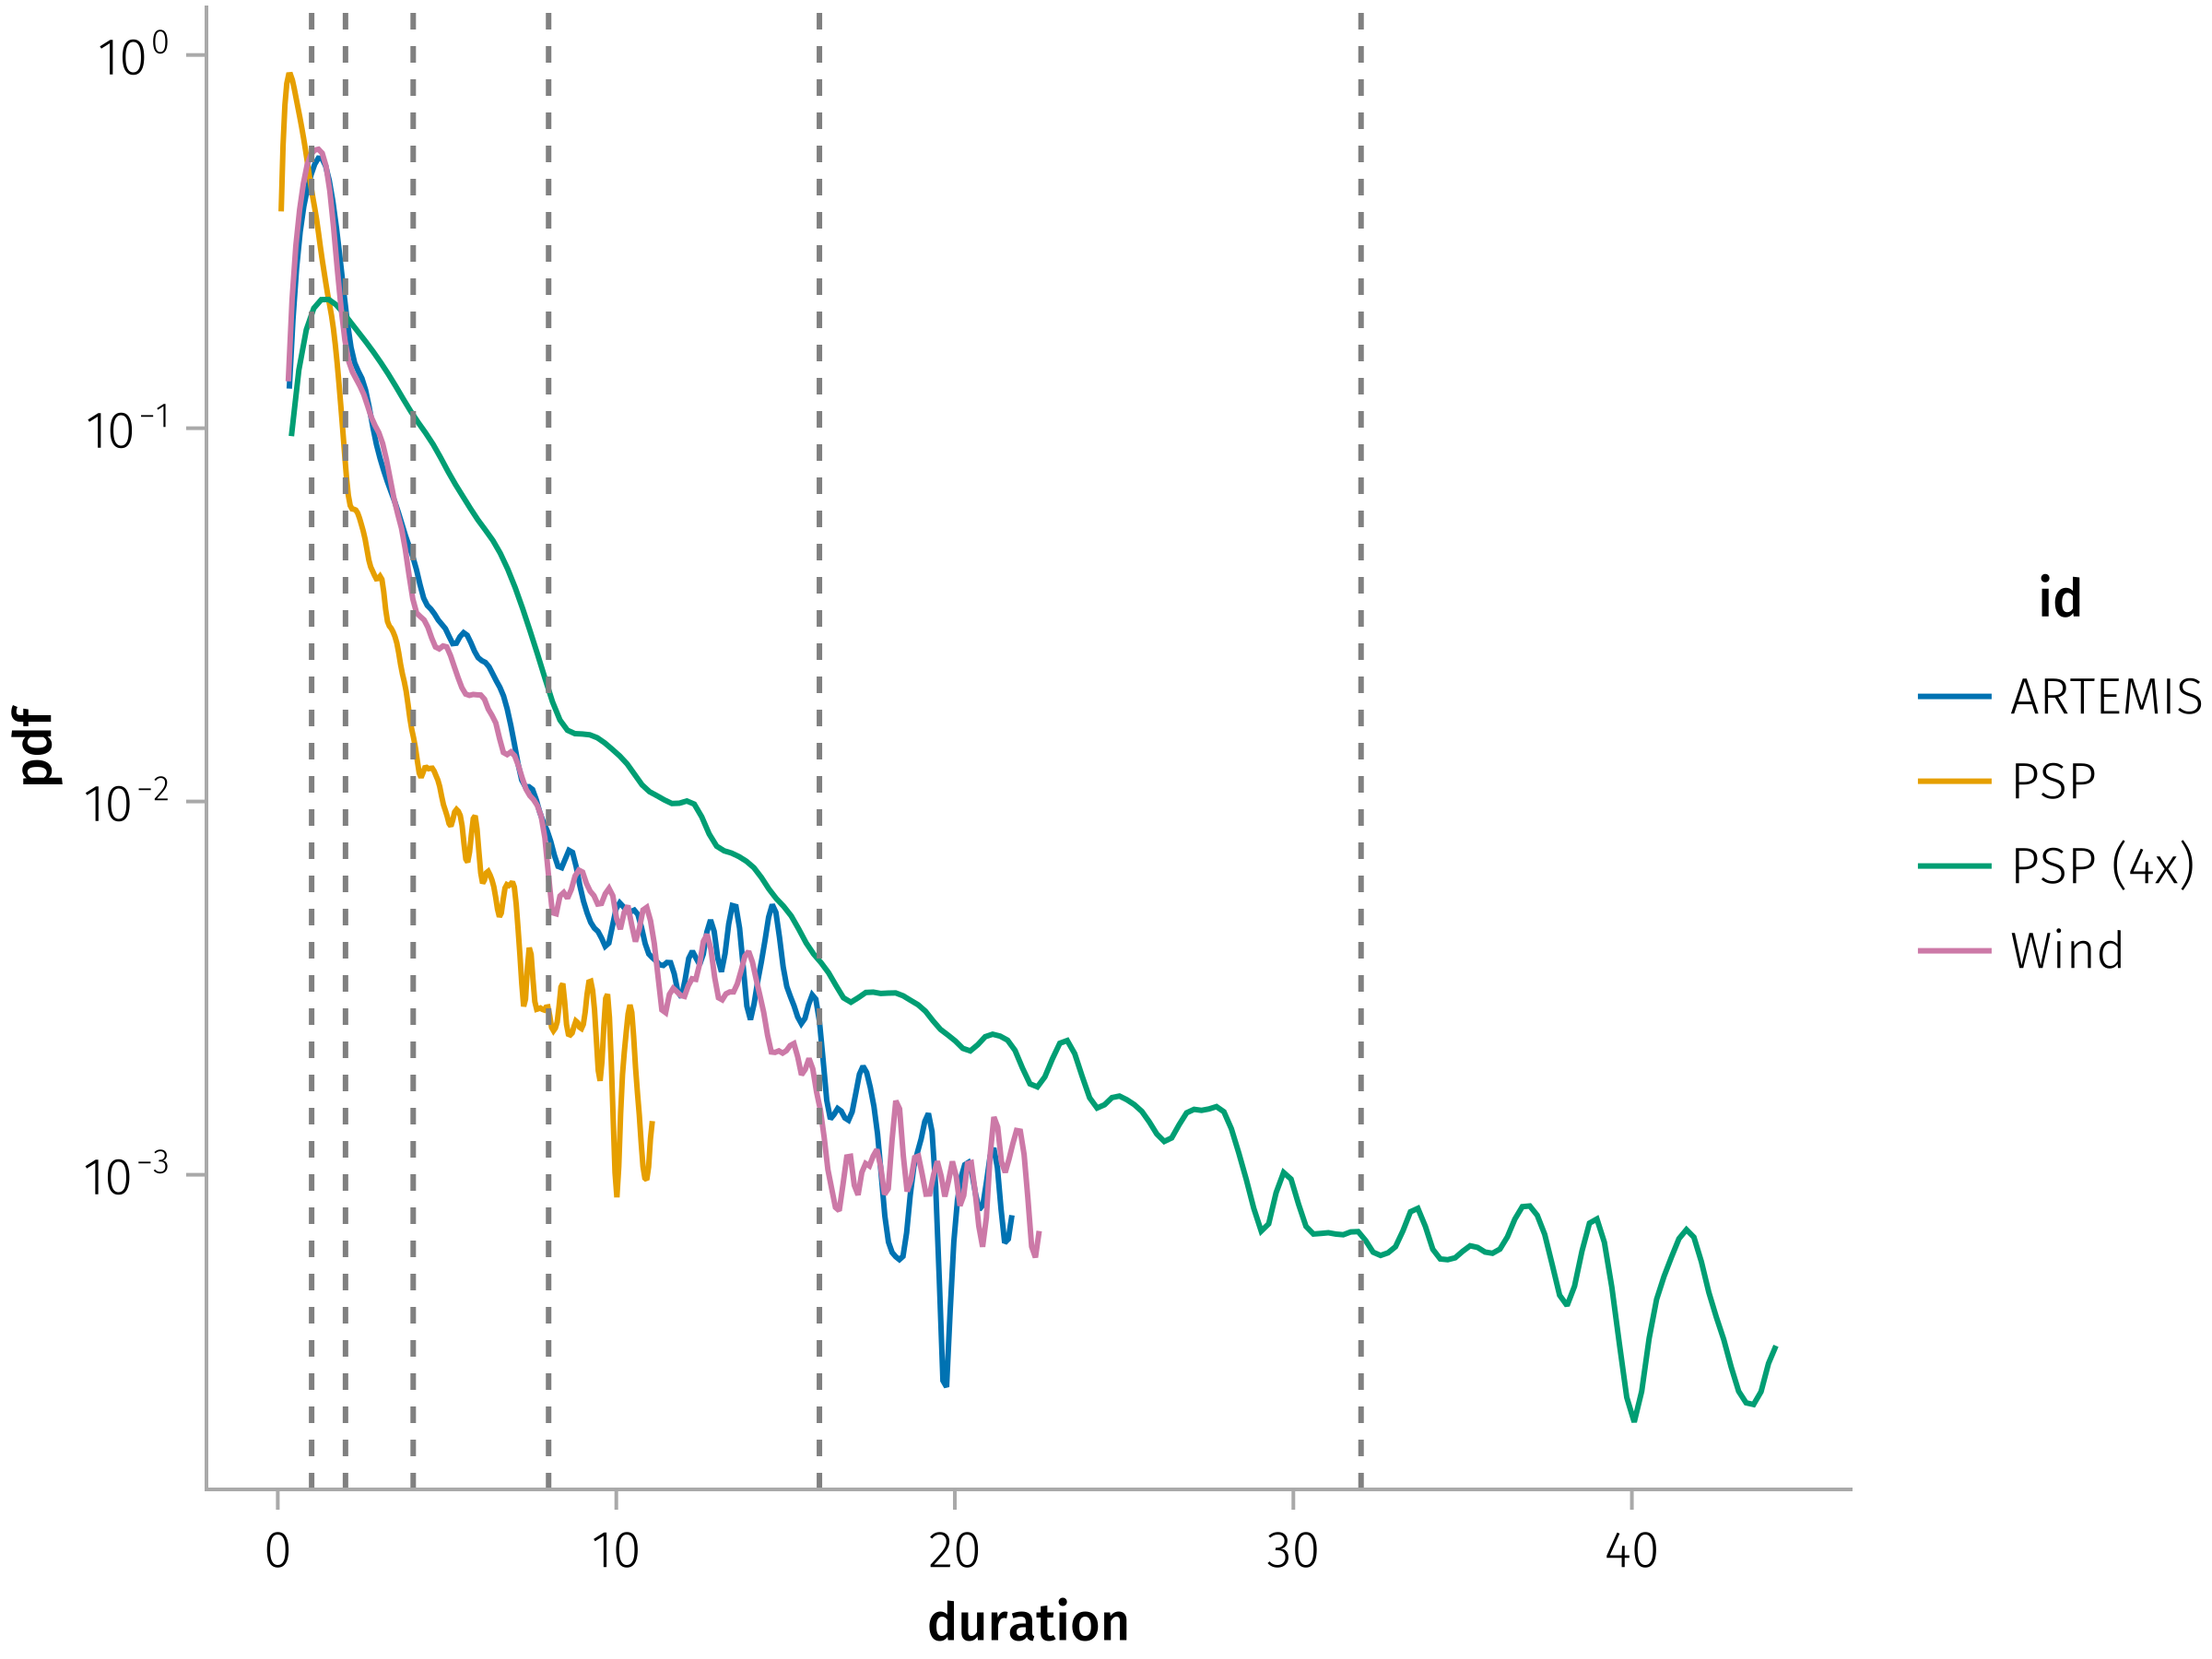

Plot duration distributions faceted by different taus:

In [0]:
let df = dropmissing(df, :duration)
    layer = AoG.density(; datalimits=x -> quantile(x, [0.02, 0.99])) * visual(Lines)
    plt = data(df) * mapping(:duration, linestyle=:enc, color=:id) * layer
    plt *= mapping(layout=:tau)
    draw(plt, axis=(; yscale=log10), facet=(; linkxaxes=:none, linkyaxes=:none))
    easy_save("duration_dist_tau")
end

## Alfvenicity

Notes: `V_l_ratio_max` and `ΔV_ratio` are pretty much similar

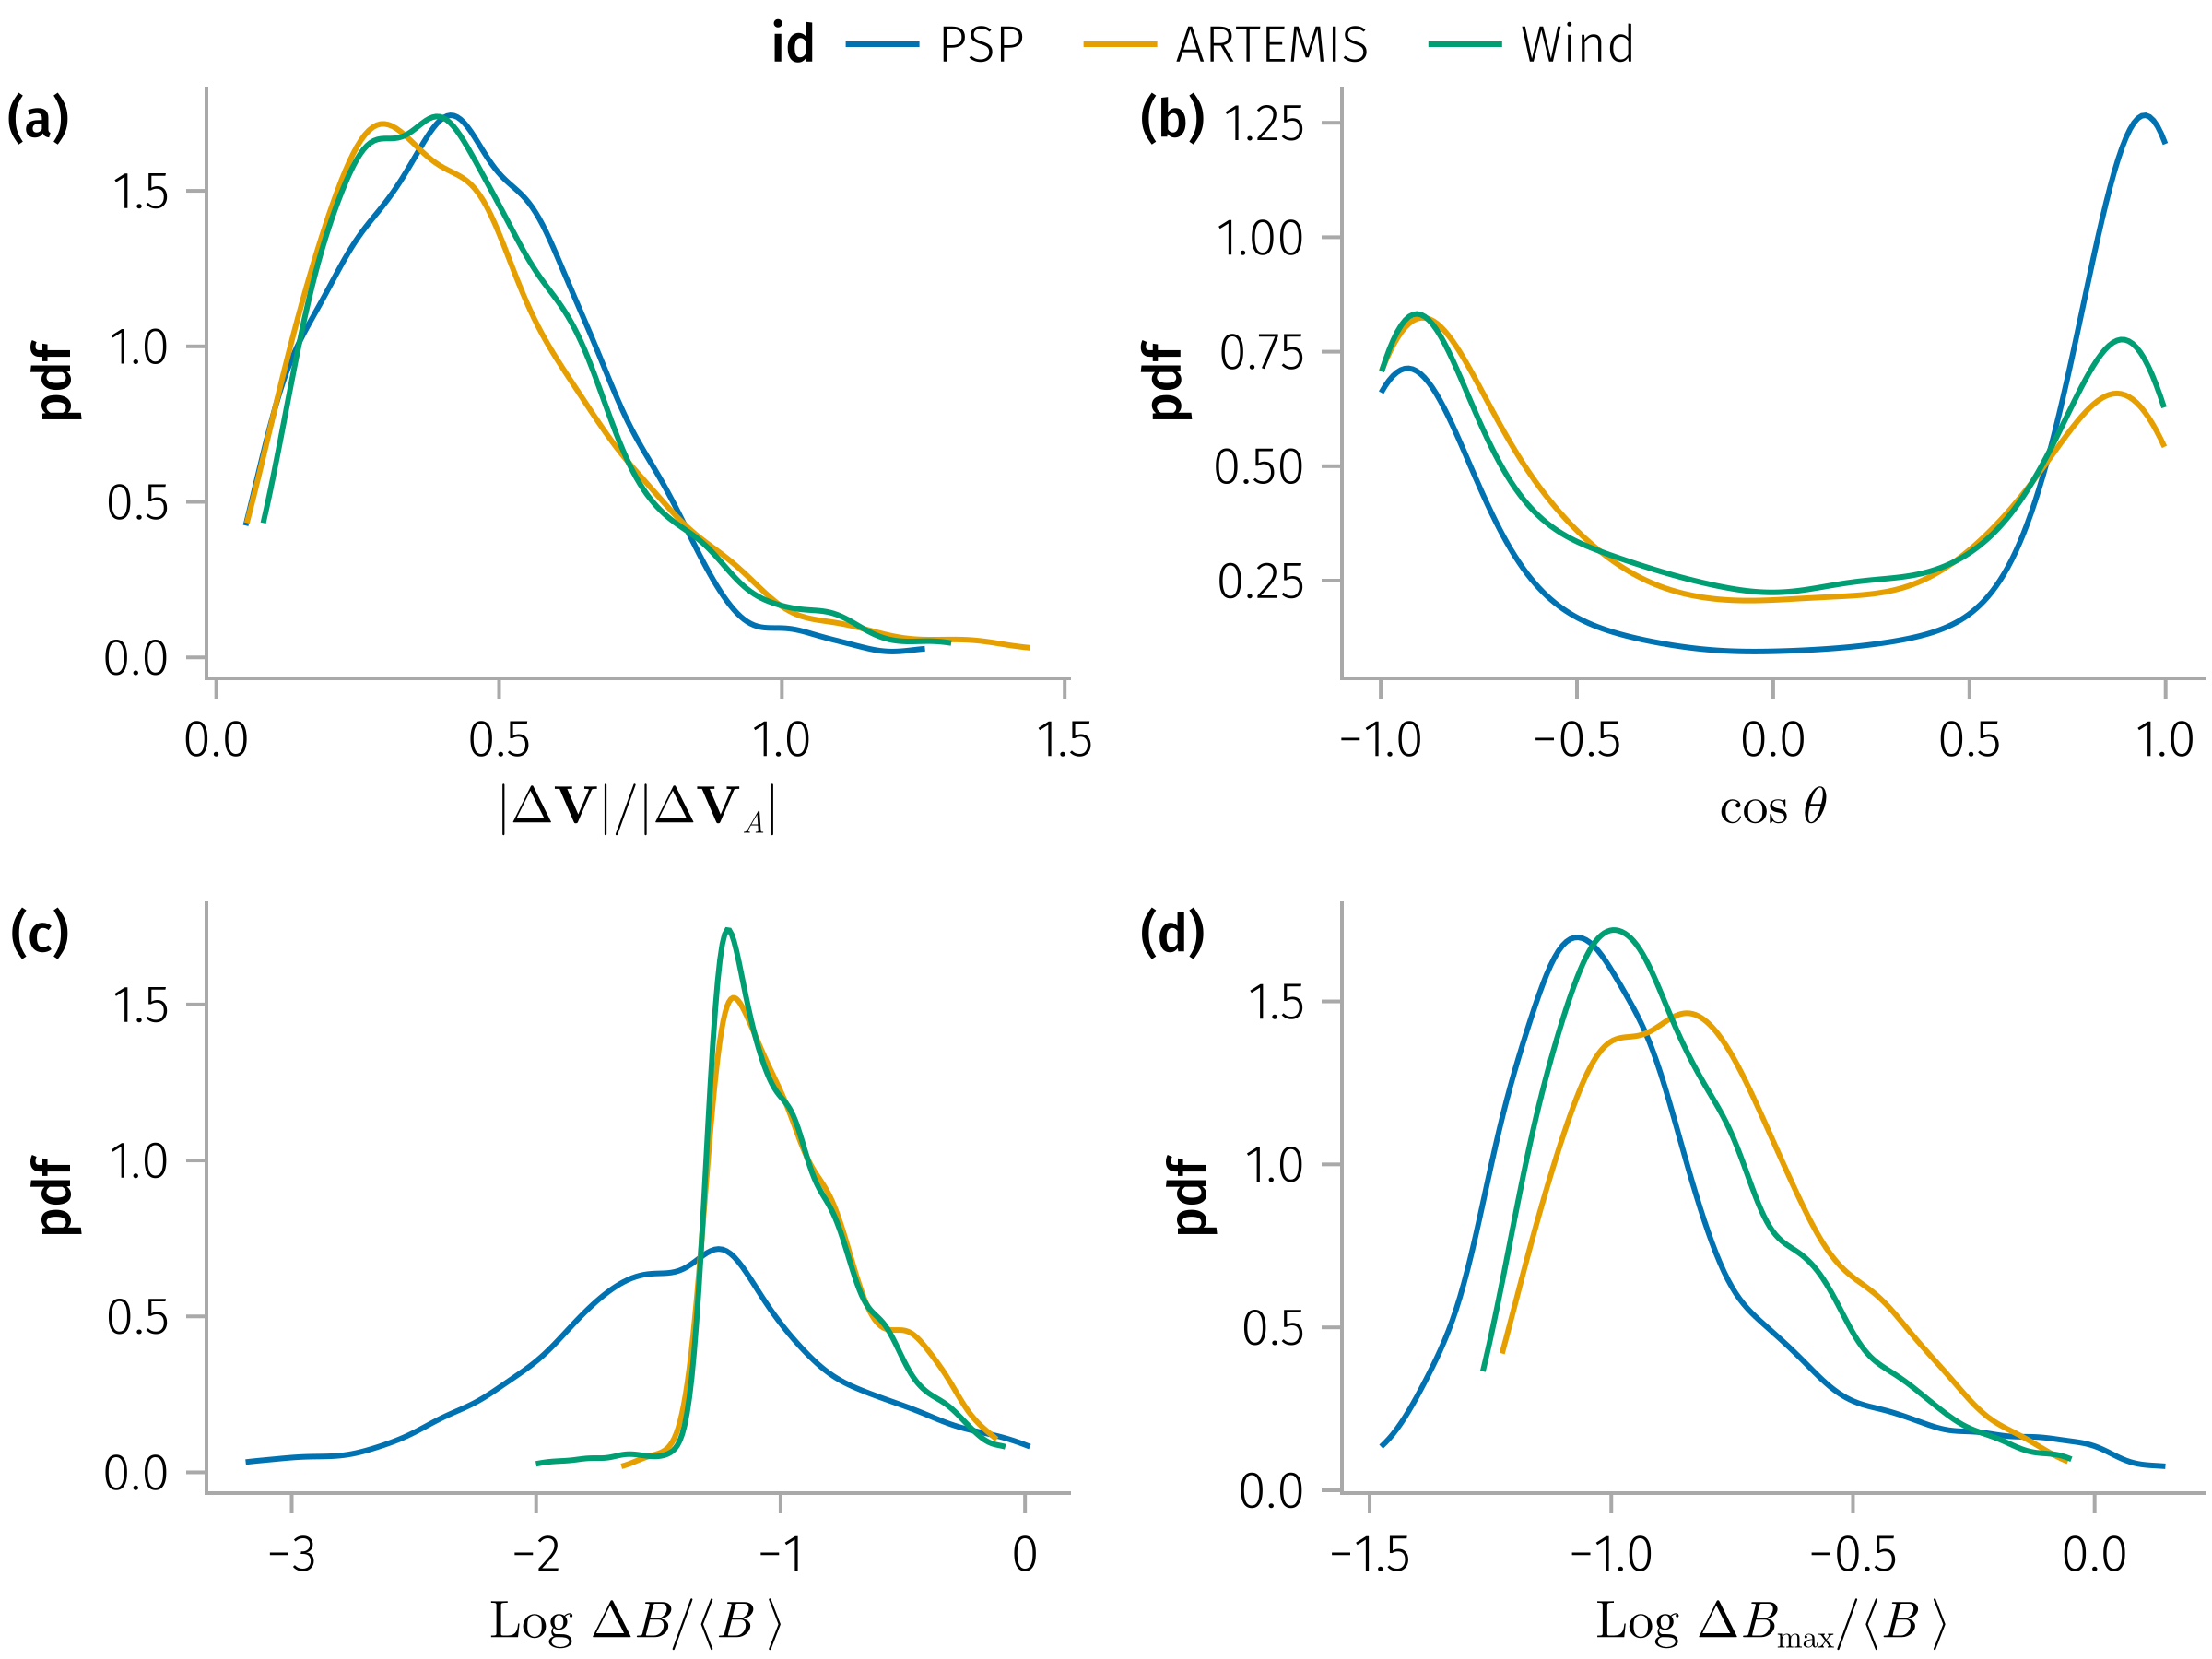

In [0]:
update_theme!(;
    Legend=(; framevisible=false, padding=(0, 0, -16, 0)),
)
let
    𝒎 = var_mapping(; 𝐧)
    datalimits = x -> quantile(x, [0.01, 0.99])
    tdf = @chain df begin
        dropmissing(:V_l_ratio)
        @subset(.!isnan.(:V_l_ratio) .&& .!isnan.(:ΔV_cosθ); view=true)
        subset_𝐧(𝐧)
    end

    ΔV_cosθ = :ΔV_cosθ => identity => L"\cos\;θ"
    ΔV_ratio = :ΔV_ratio => identity => L"|Δ𝐕| / |Δ𝐕_A|"
    dB_over_B = :dB_over_B => log10 => L"\text{Log } ΔB / ⟨B\;⟩"
    dB_max_over_B = :dB_max_over_B => log10 => L"\text{Log } ΔB_{\text{max}} / ⟨B\;⟩"
    Q_sonnerup = :Q_sonnerup => abs => ""

    spec = AoG.data(tdf) * mapping(color=:id) *
           AoG.density(; datalimits) * visual(Lines)

    fig = Figure()
    ga = draw!(fig[1, 1], spec * mapping(ΔV_ratio))
    gb = draw!(fig[1, 2], spec * mapping(ΔV_cosθ))
    gc = draw!(fig[2, 1], spec * mapping(dB_over_B))
    gd = draw!(fig[2, 2], spec * mapping(dB_max_over_B))
    add_labels!(fig; valign=:top, position=Left(), padding=(0, 37, 0, 0))
    display(fig)
    pretty_legend!(fig, ga)
    easy_save("Alfvenicities"; force=true)
    # vars = [ΔV_cosθ, ΔV_ratio, dB_over_B, dB_max_over_B]
    # plt = spec * mapping(vars, layout=AoG.dims(1) => renamer(labels))
    # draw(plt, axis=(; yscale=log10), facet=(; linkyaxes=:minimal))
end

## Joint distributions

### Thickness and current density

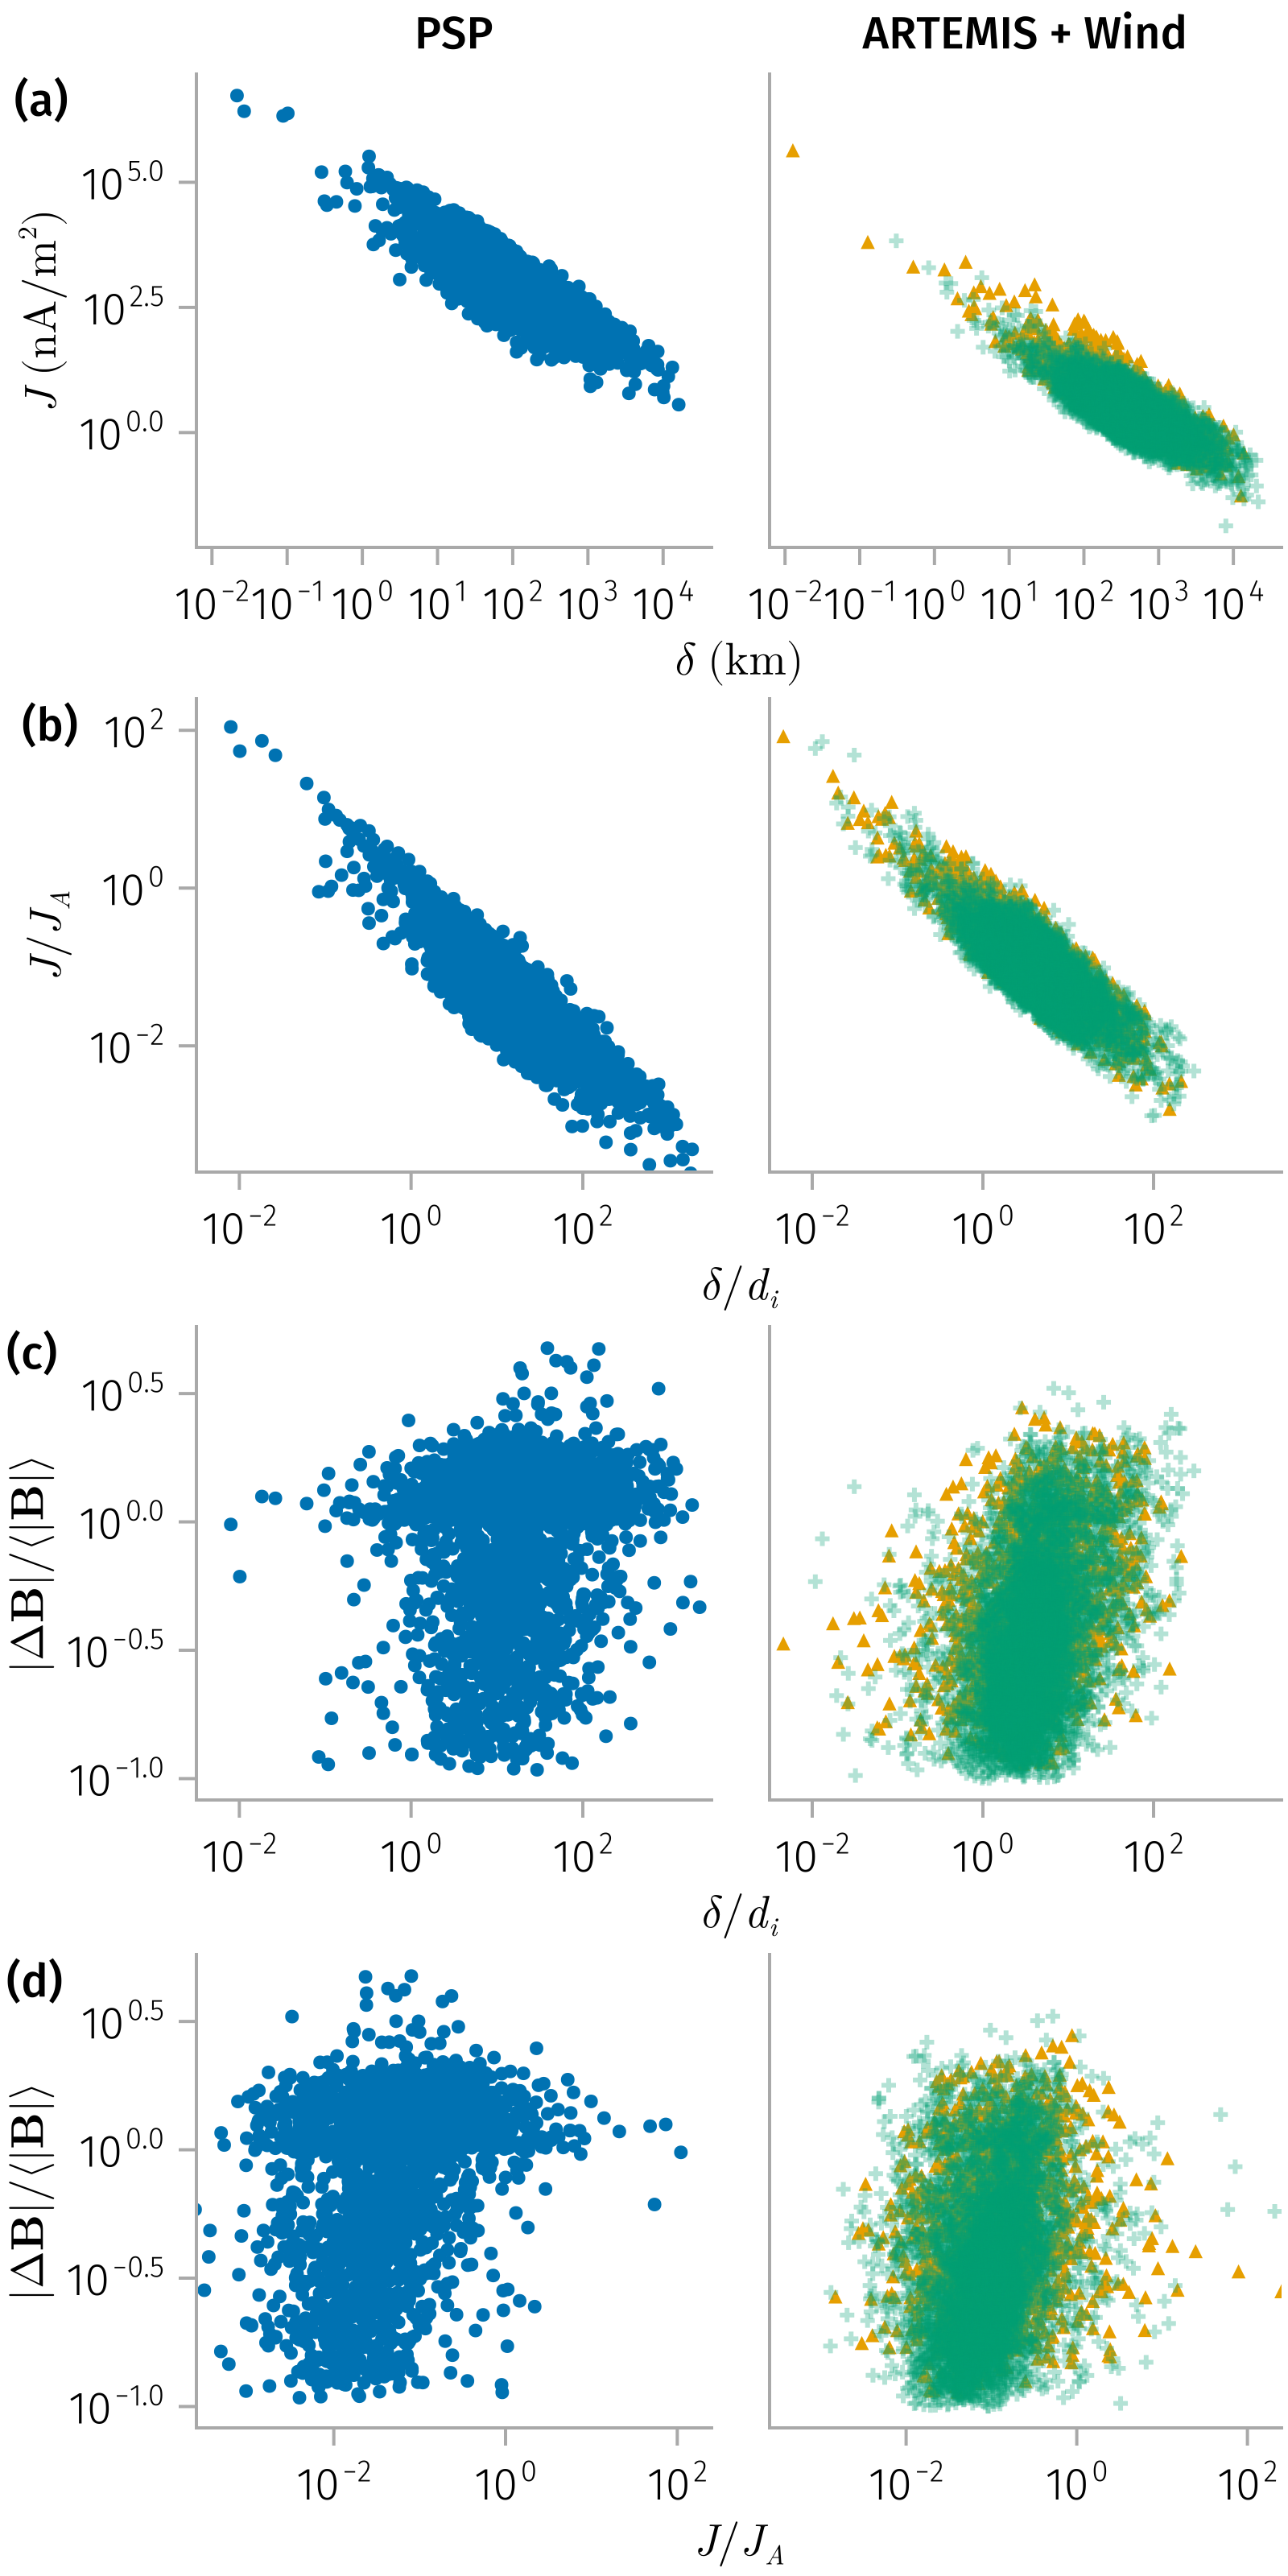

In [0]:
function alpha_layer(df, alpha)
    psp_df = @rsubset(df, :id == "PSP"; view=true)
    thm_df = @rsubset(df, :id ∈ ("ARTEMIS", "THEMIS"); view=true)
    wind_df = @rsubset(df, :id == "Wind"; view=true)
    AoG.data(psp_df) + (AoG.data(thm_df) + AoG.data(wind_df) * visual(; alpha))
end

In [0]:
for 𝐧 in [:mva, :cross]
    view = true
    𝒎 = var_mapping(; 𝐧)

    l_sym = first(𝒎.l_norm)

    tdf = @chain df begin
        dropmissing(l_sym)
        subset_𝐧(𝐧)
    end

    plt = alpha_layer(tdf, 0.3) *
          visual(Scatter; markersize=6, legend=(; alpha=0.6)) *
          mapping(color=:id, marker=:id, layout=:id => layout_func)

    fig = Figure(; size=(400, 800))
    axis = (; yscale=log10, xscale=log10)

    spec1 = plt * mapping(𝒎.l, 𝒎.j)
    spec2 = plt * mapping(𝒎.l_norm, 𝒎.j_norm)
    B_l_spec = plt * mapping(𝒎.l_norm, 𝒎.Δ𝐁_norm) # Not strong correlation
    B_j_spec = plt * mapping(𝒎.j_norm, 𝒎.Δ𝐁_norm) # Not strong correlation

    d_lims = (10^(-2.5), 10^3.5)
    j_lims = (10^(-3.6), 10^2.4)
    B_lims = (10^(-3), 10^3)

    grid1 = draw!(fig[1, 1], spec1; axis)
    grid2 = draw!(fig[2, 1], spec2; axis=(; axis..., limits=(d_lims, j_lims)))
    grid3 = draw!(fig[3, 1], B_l_spec; axis=(; axis..., limits=(d_lims, nothing)))
    grid4 = draw!(fig[4, 1], B_j_spec; axis=(; axis..., limits=(j_lims, nothing)))

    hide_facet_labels!.((grid2, grid3, grid4))
    rowgap!(fig.layout, 4)

    add_labels!([fig[1, 1], fig[2, 1], fig[3, 1], fig[4, 1]]; position=Left(), padding=(0, 37, 0, 0))
    display(fig)
    easy_save("joint_properties-$𝐧"; force=true)
    # easy_save("joint_properties-$𝐧")
end

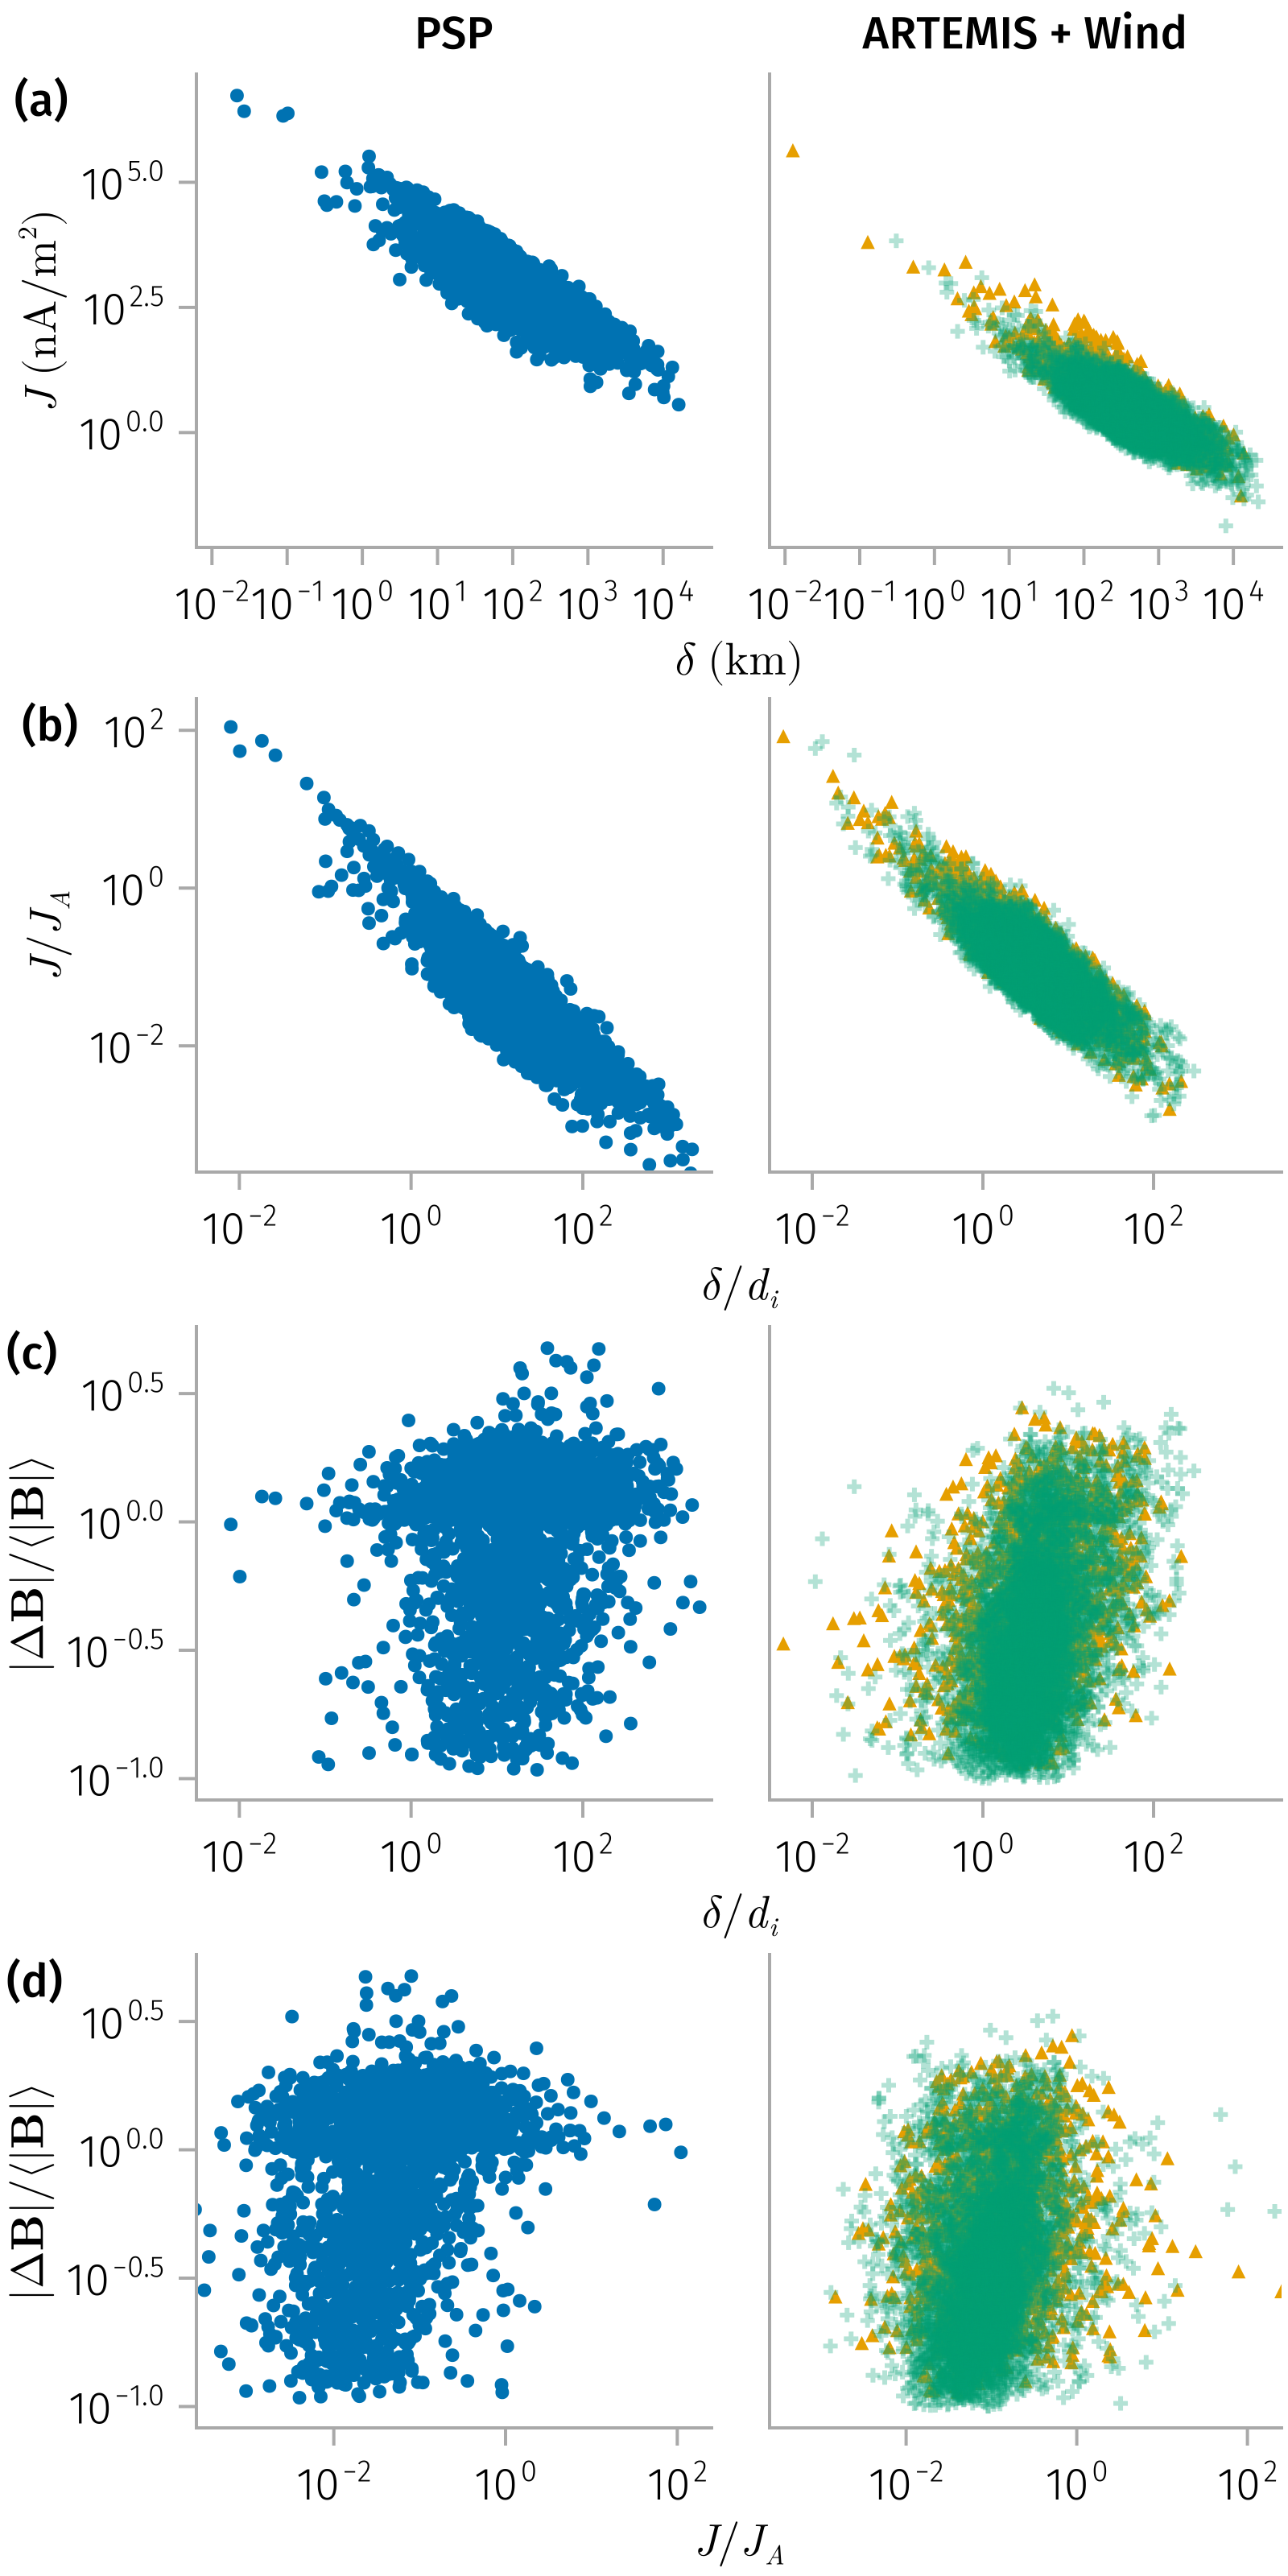
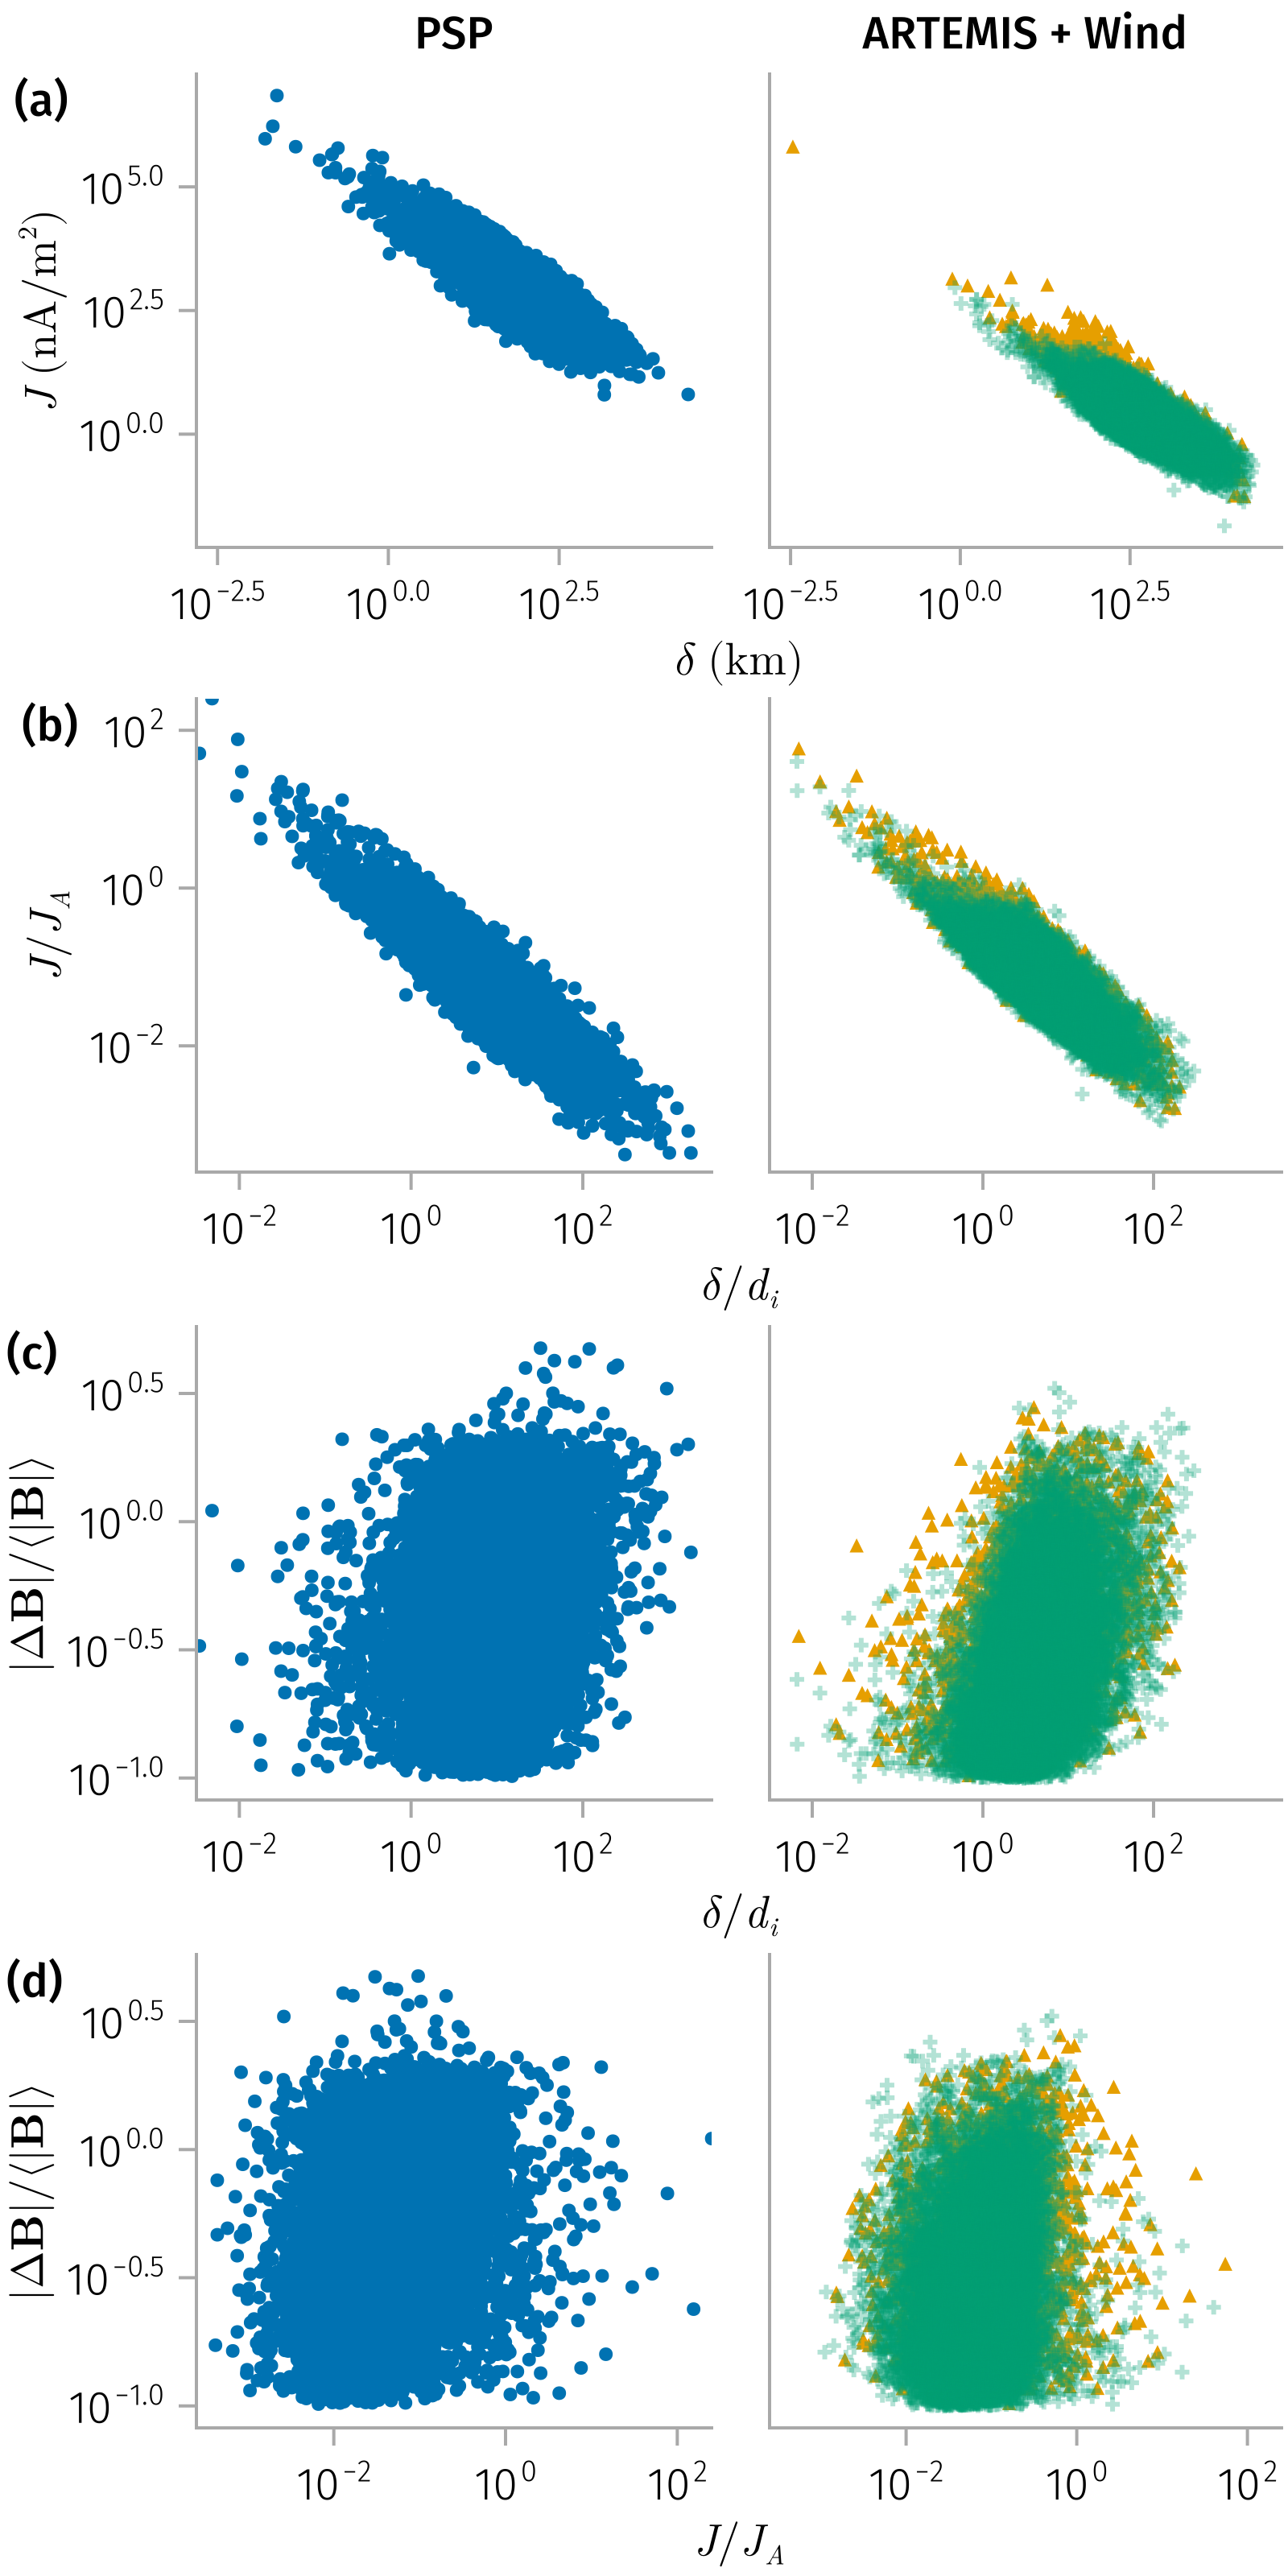

### In-plane rotation angle, Bn

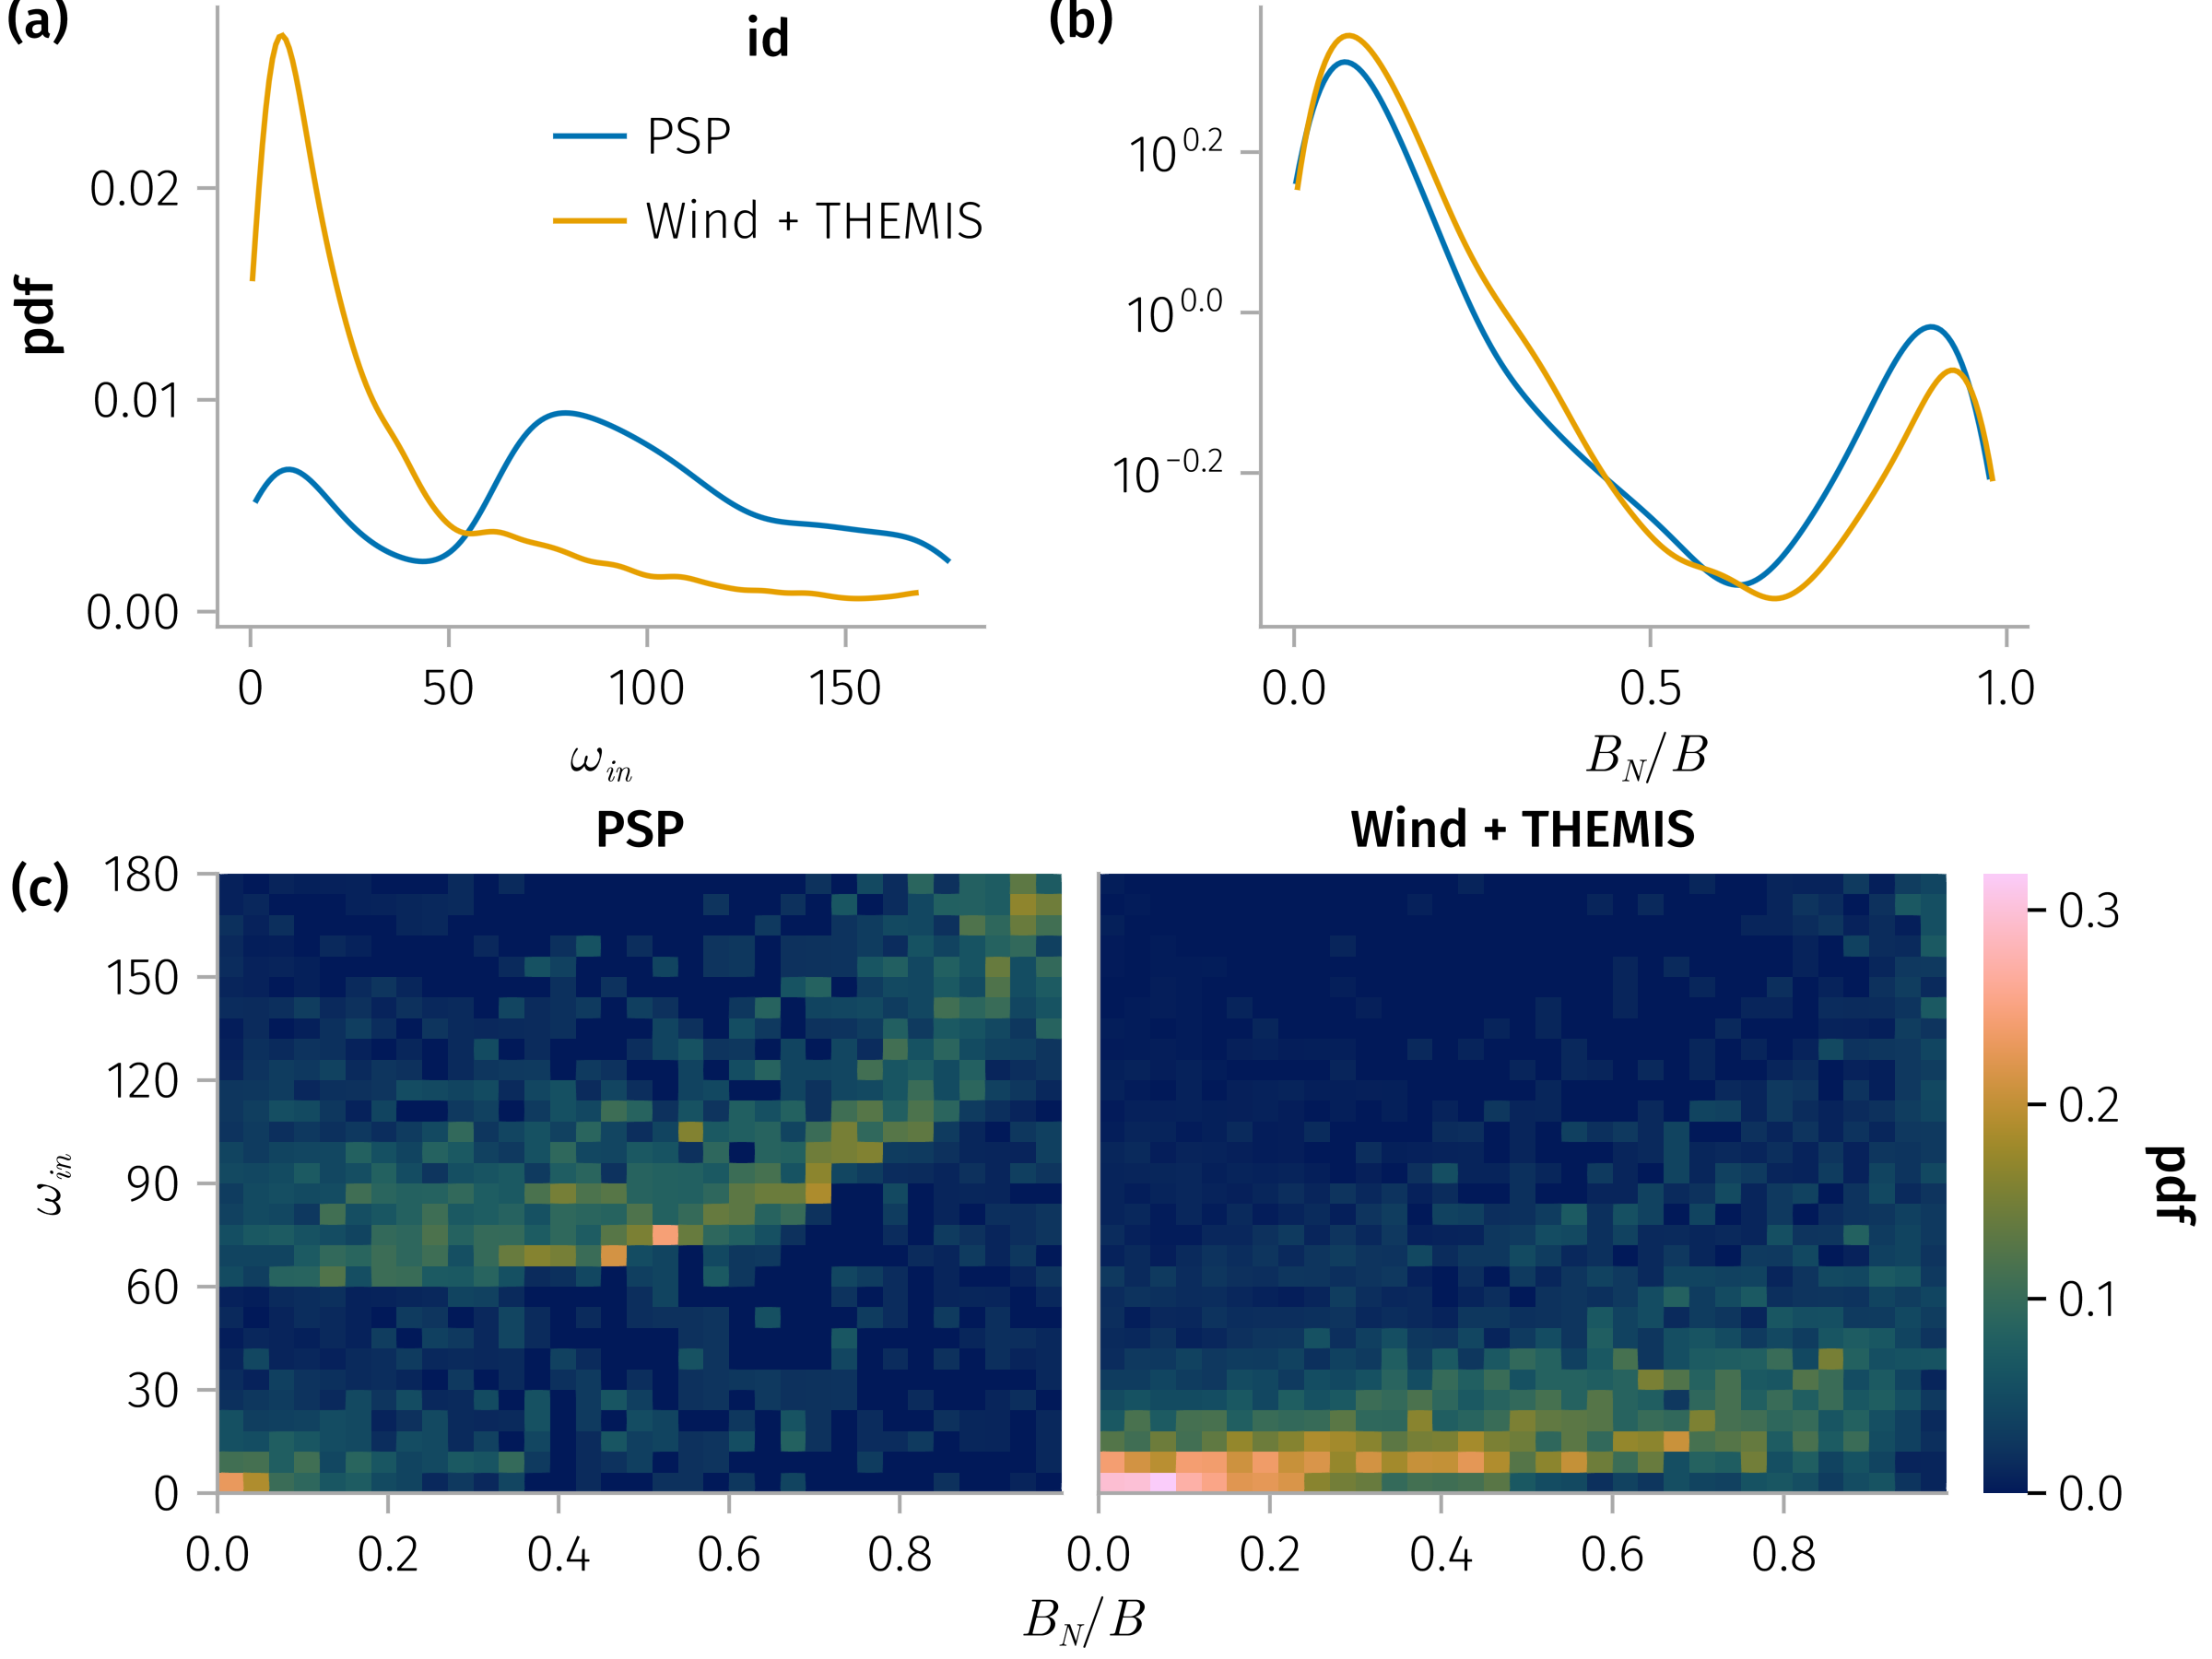 and 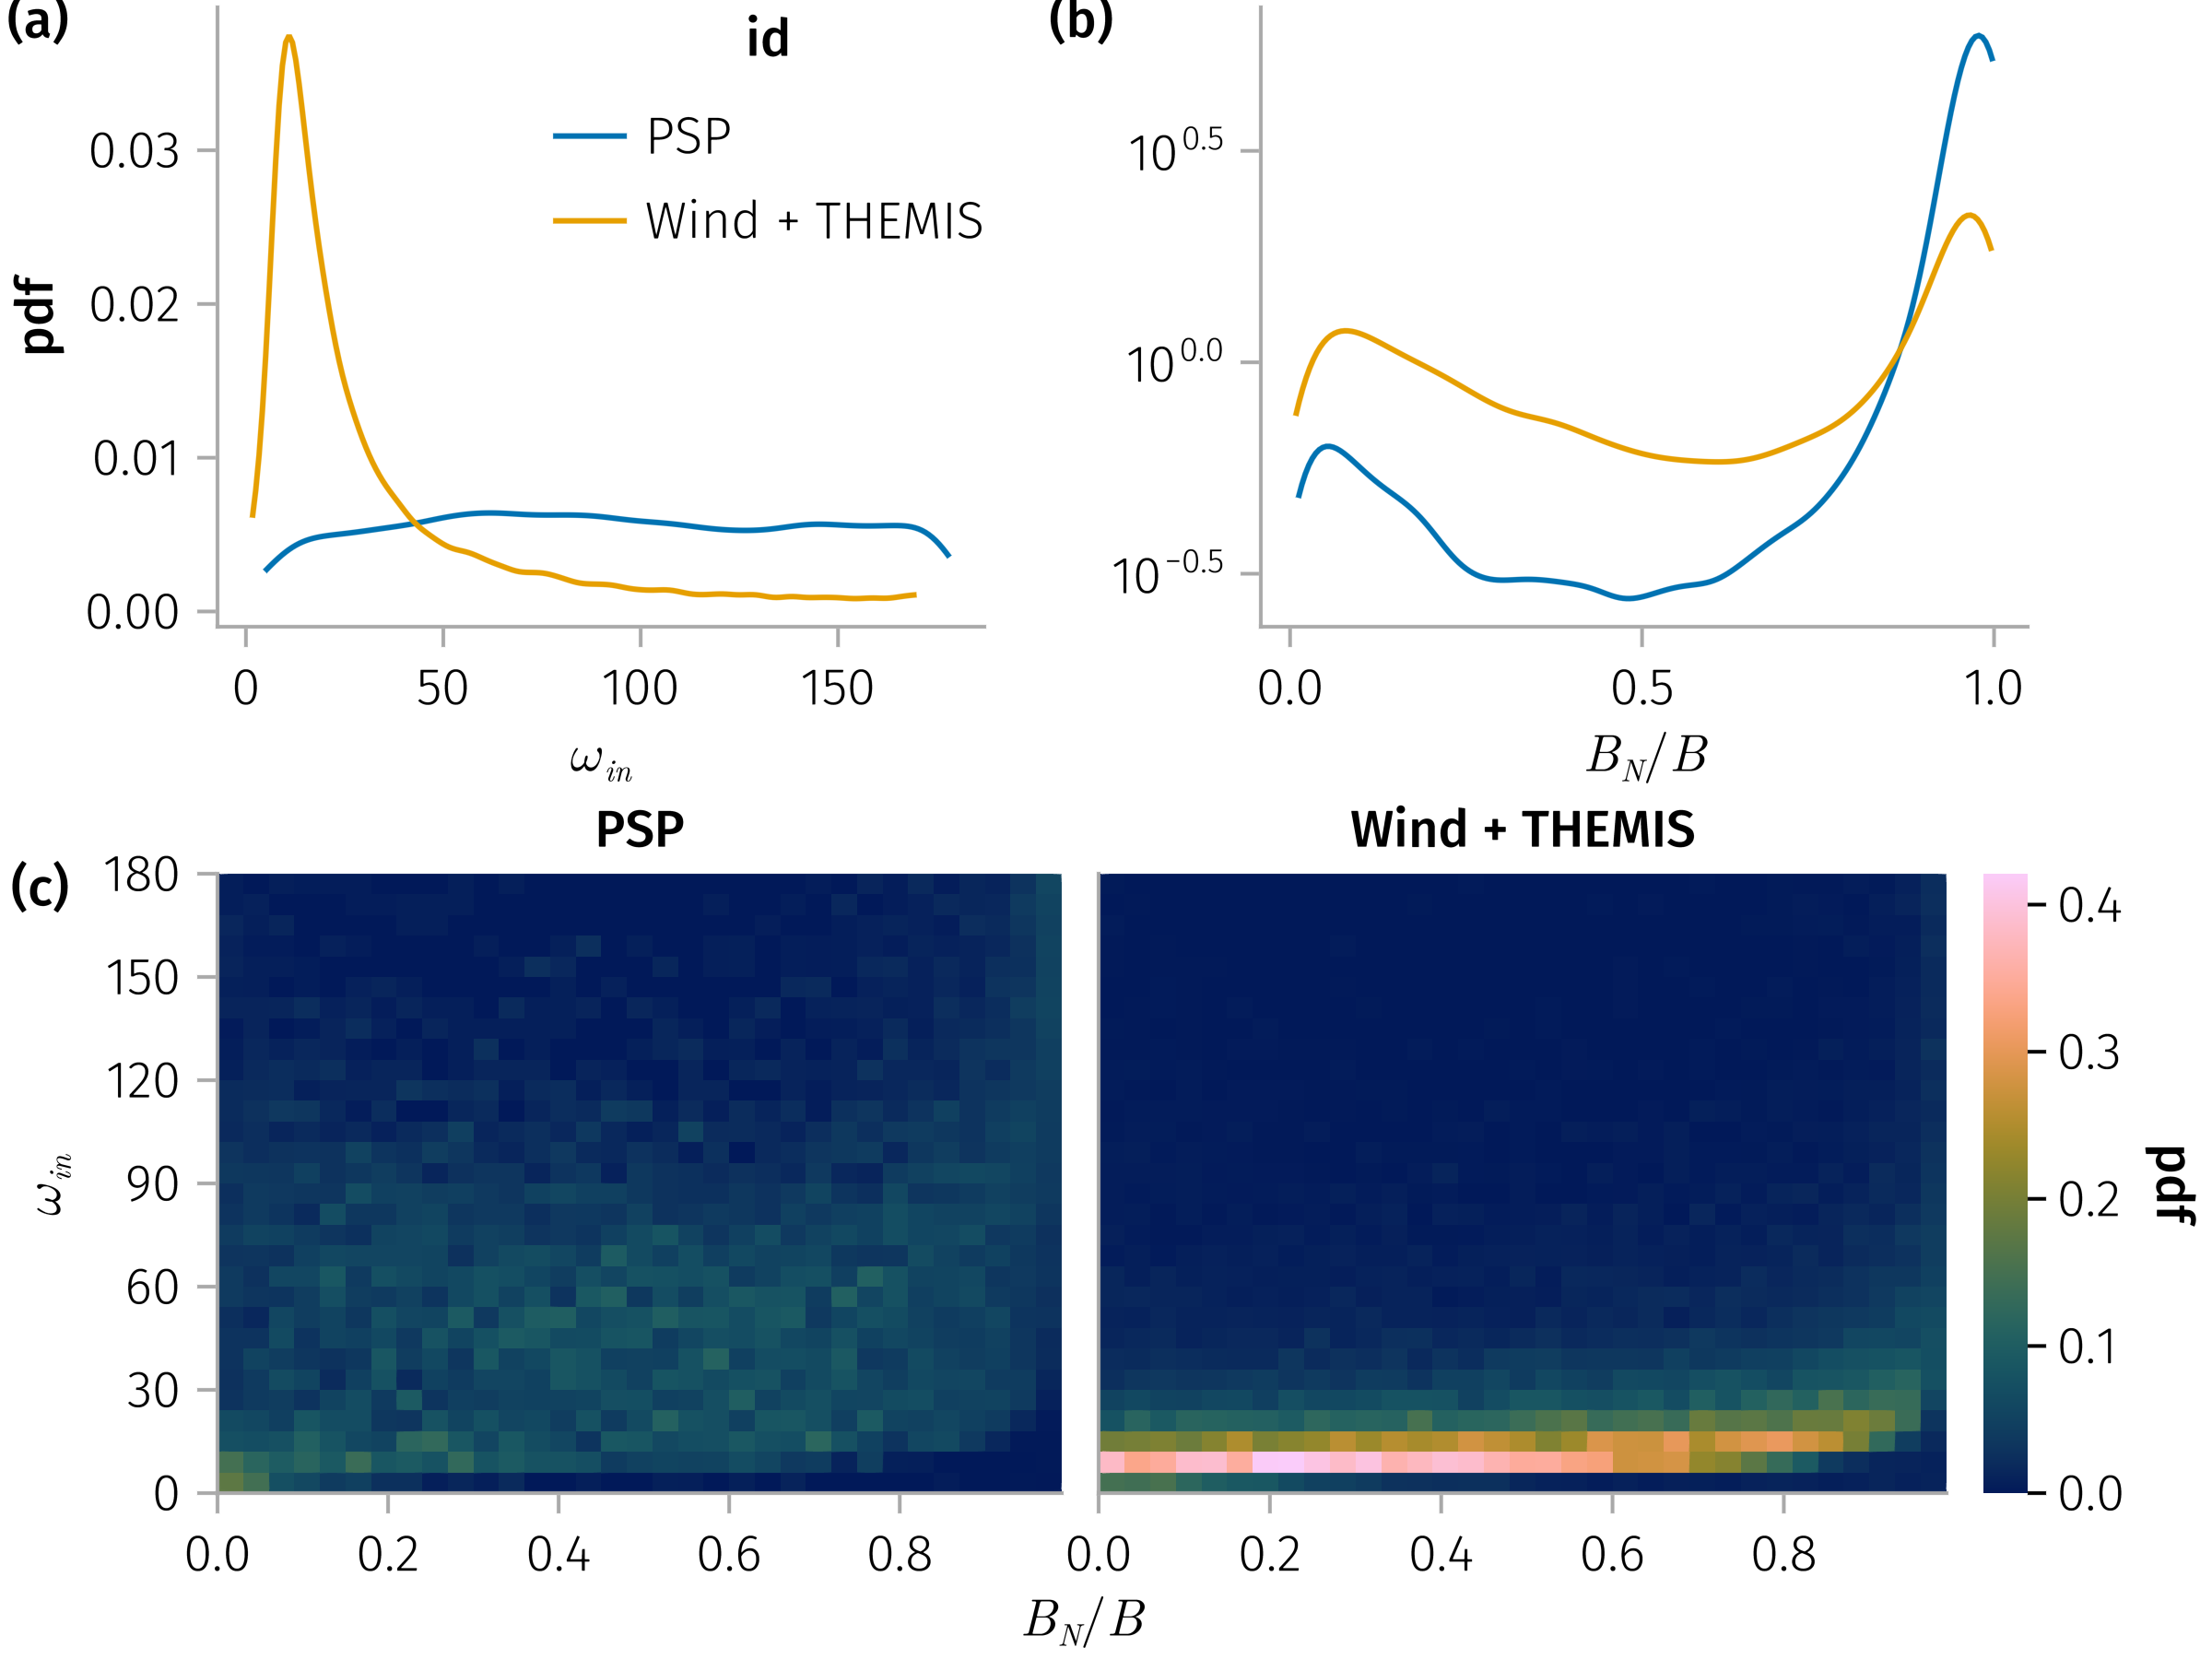

In [0]:
for 𝐧 in [:mva, :cross], subset in (true)
    normalization = :column
    𝒎 = var_mapping(; 𝐧)
    B_sym = Symbol(:B_n_, 𝐧)
    tdf = dropmissing(df, B_sym)
    # tdf = subset ? subset_𝐧(tdf, 𝐧) : tdf
    tdf = subset_𝐧(tdf, 𝐧)
    plt = AoG.data(tdf) * mapping(col=:id => layout_func)
    B_n_ω_spec = plt * mapping(𝒎.bn, 𝒎.ω_in) * fhist(; binedges=(0:0.03:0.99, 0:6:180), normalization)
    f = draw(B_n_ω_spec)
    colgap!(f.figure.layout, 10)

    den_base = AoG.data(tdf) * mapping(color=:id => layout_func) * AoG.density(; datalimits) * visual(Lines)
    ff = f.figure[0, 1:3]
    grid1 = draw!(ff[1, 1], den_base * mapping(𝒎.ω_in))
    grid2 = draw!(ff[1, 2], den_base * mapping(𝒎.bn); axis=(; ylabel="", yscale=log10))
    legend!(ff[1, 1], grid1; tellheight=false, tellwidth=false, halign=:right, valign=:top)
    rowgap!(f.figure.layout, 4)
    add_labels!([ff[1, 1], ff[1, 2], f.figure[1, 1:end]]; position=Left(), padding=(0, 40, 0, -5))
    easy_save("B_n_ω_-$𝐧-subset=$subset"; force=true)
    # easy_save("B_n_ω_-$𝐧-subset=$subset")
end

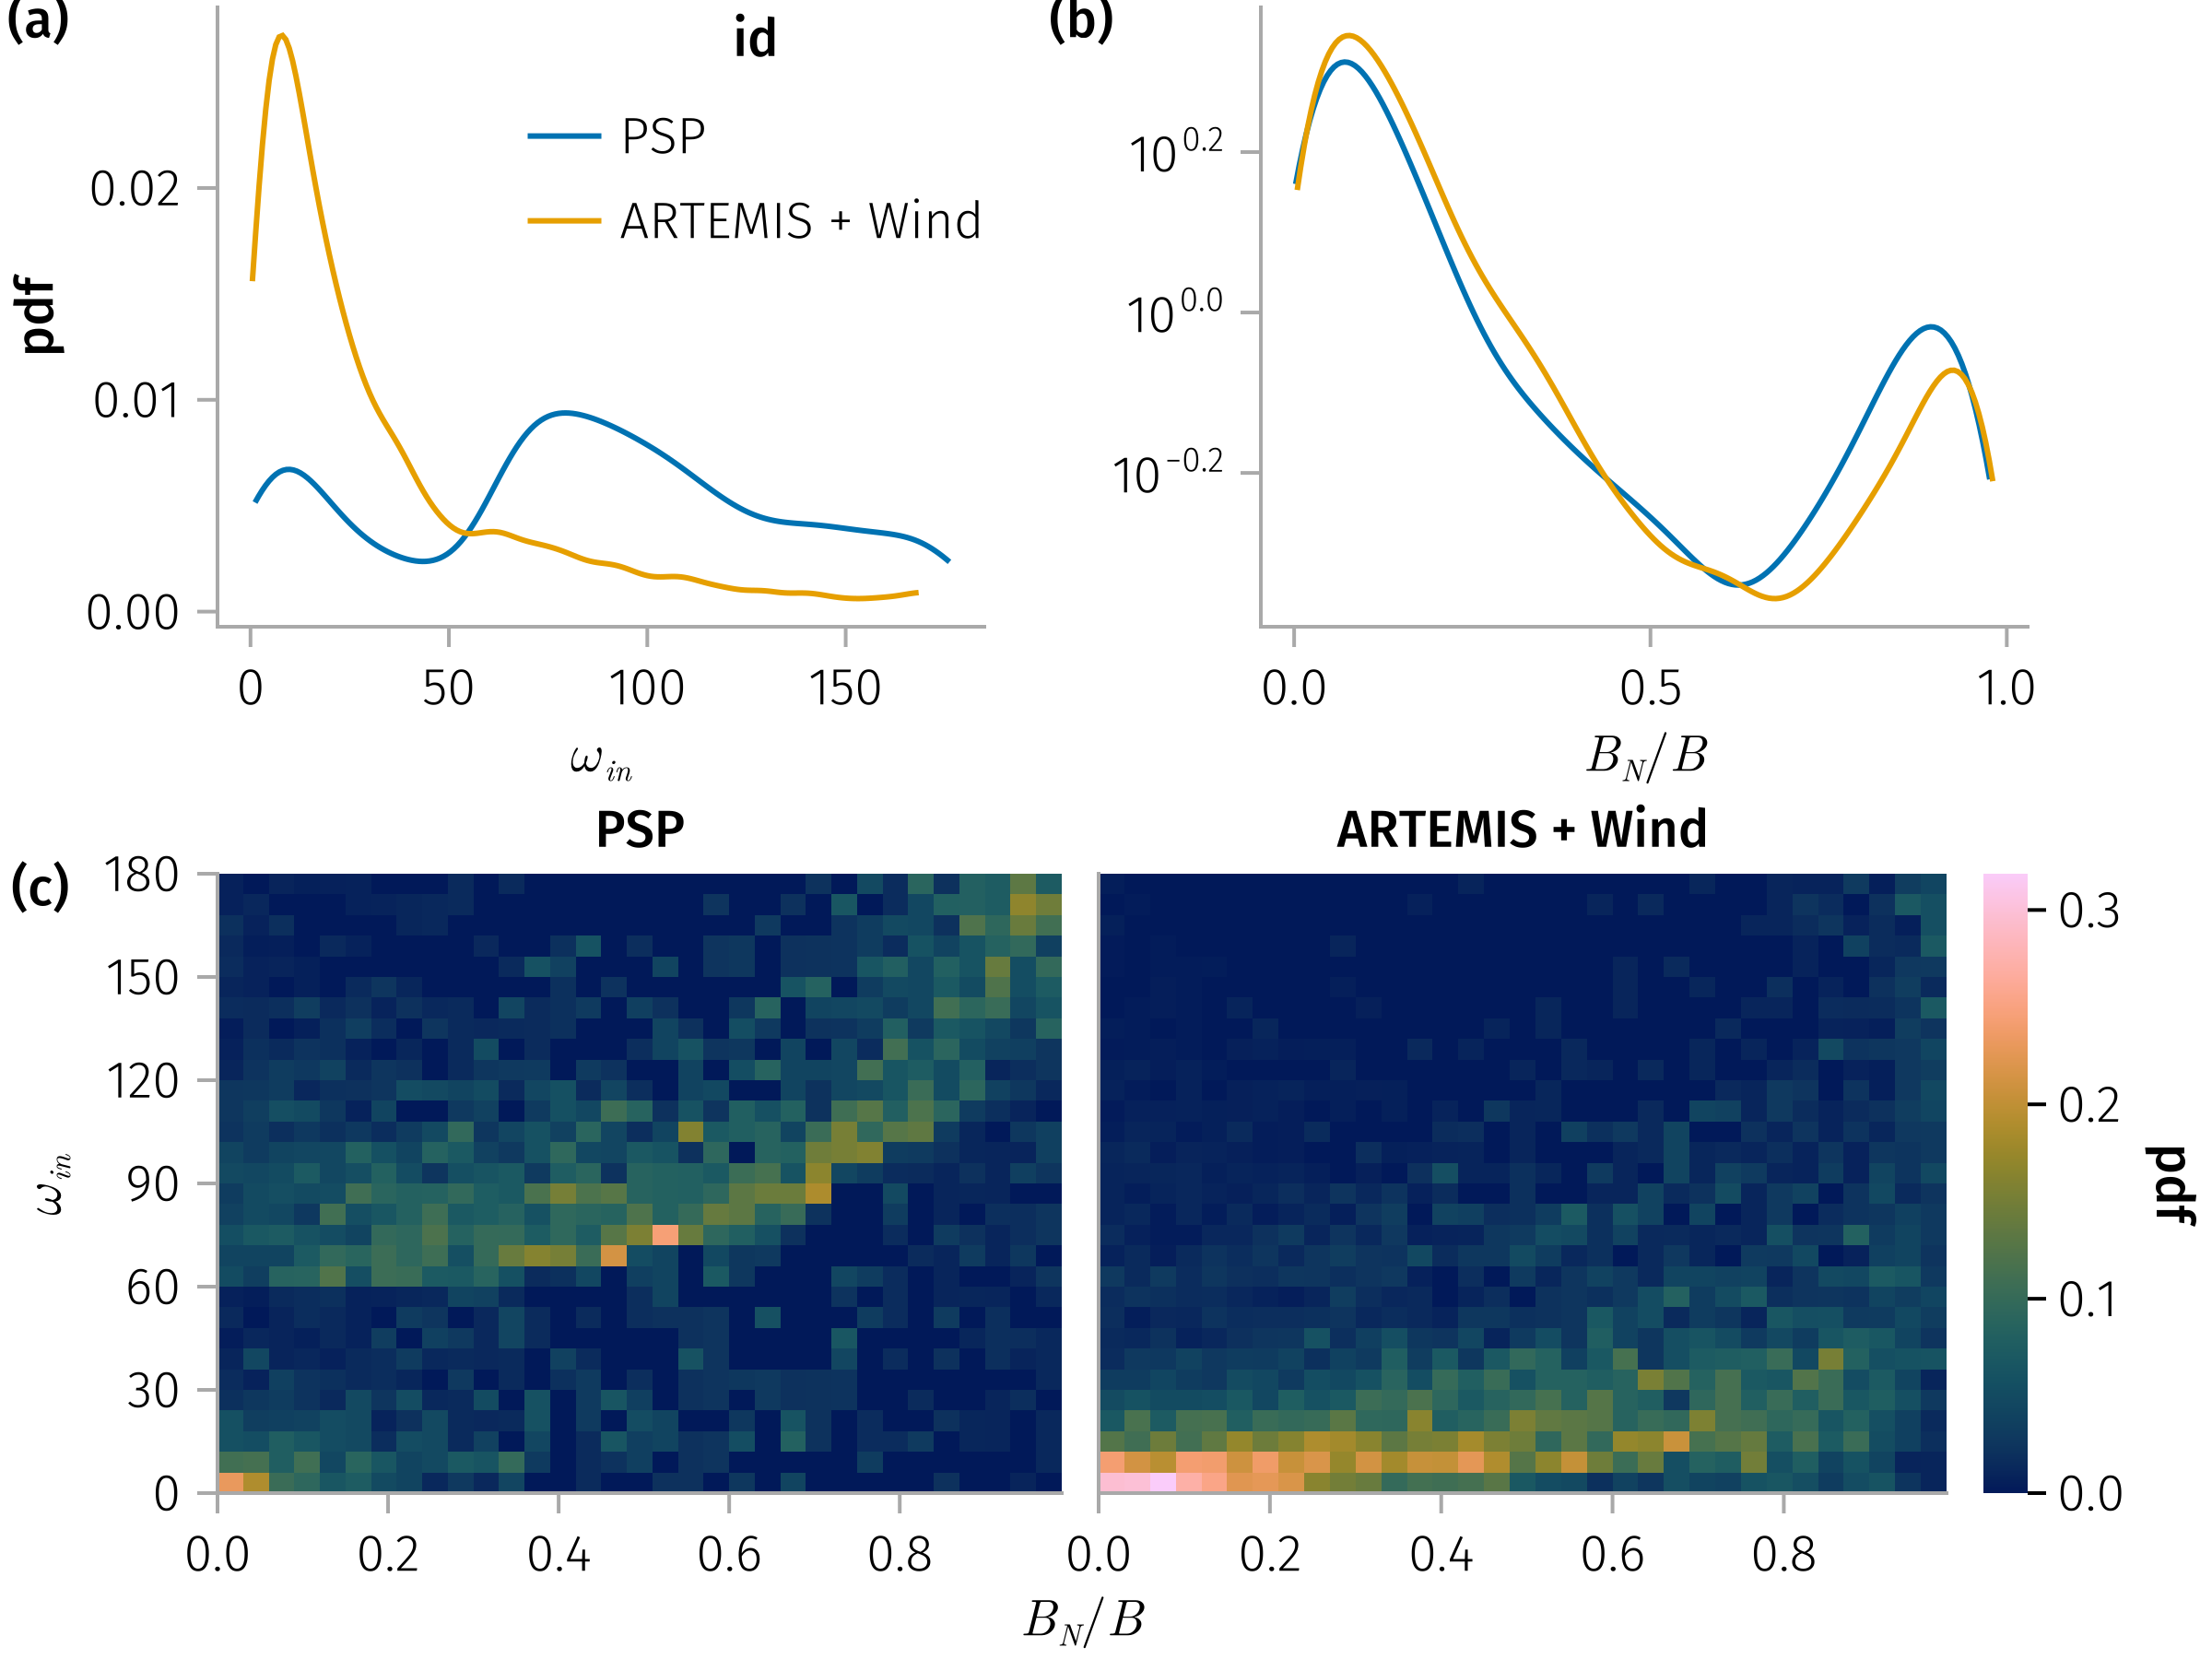 and 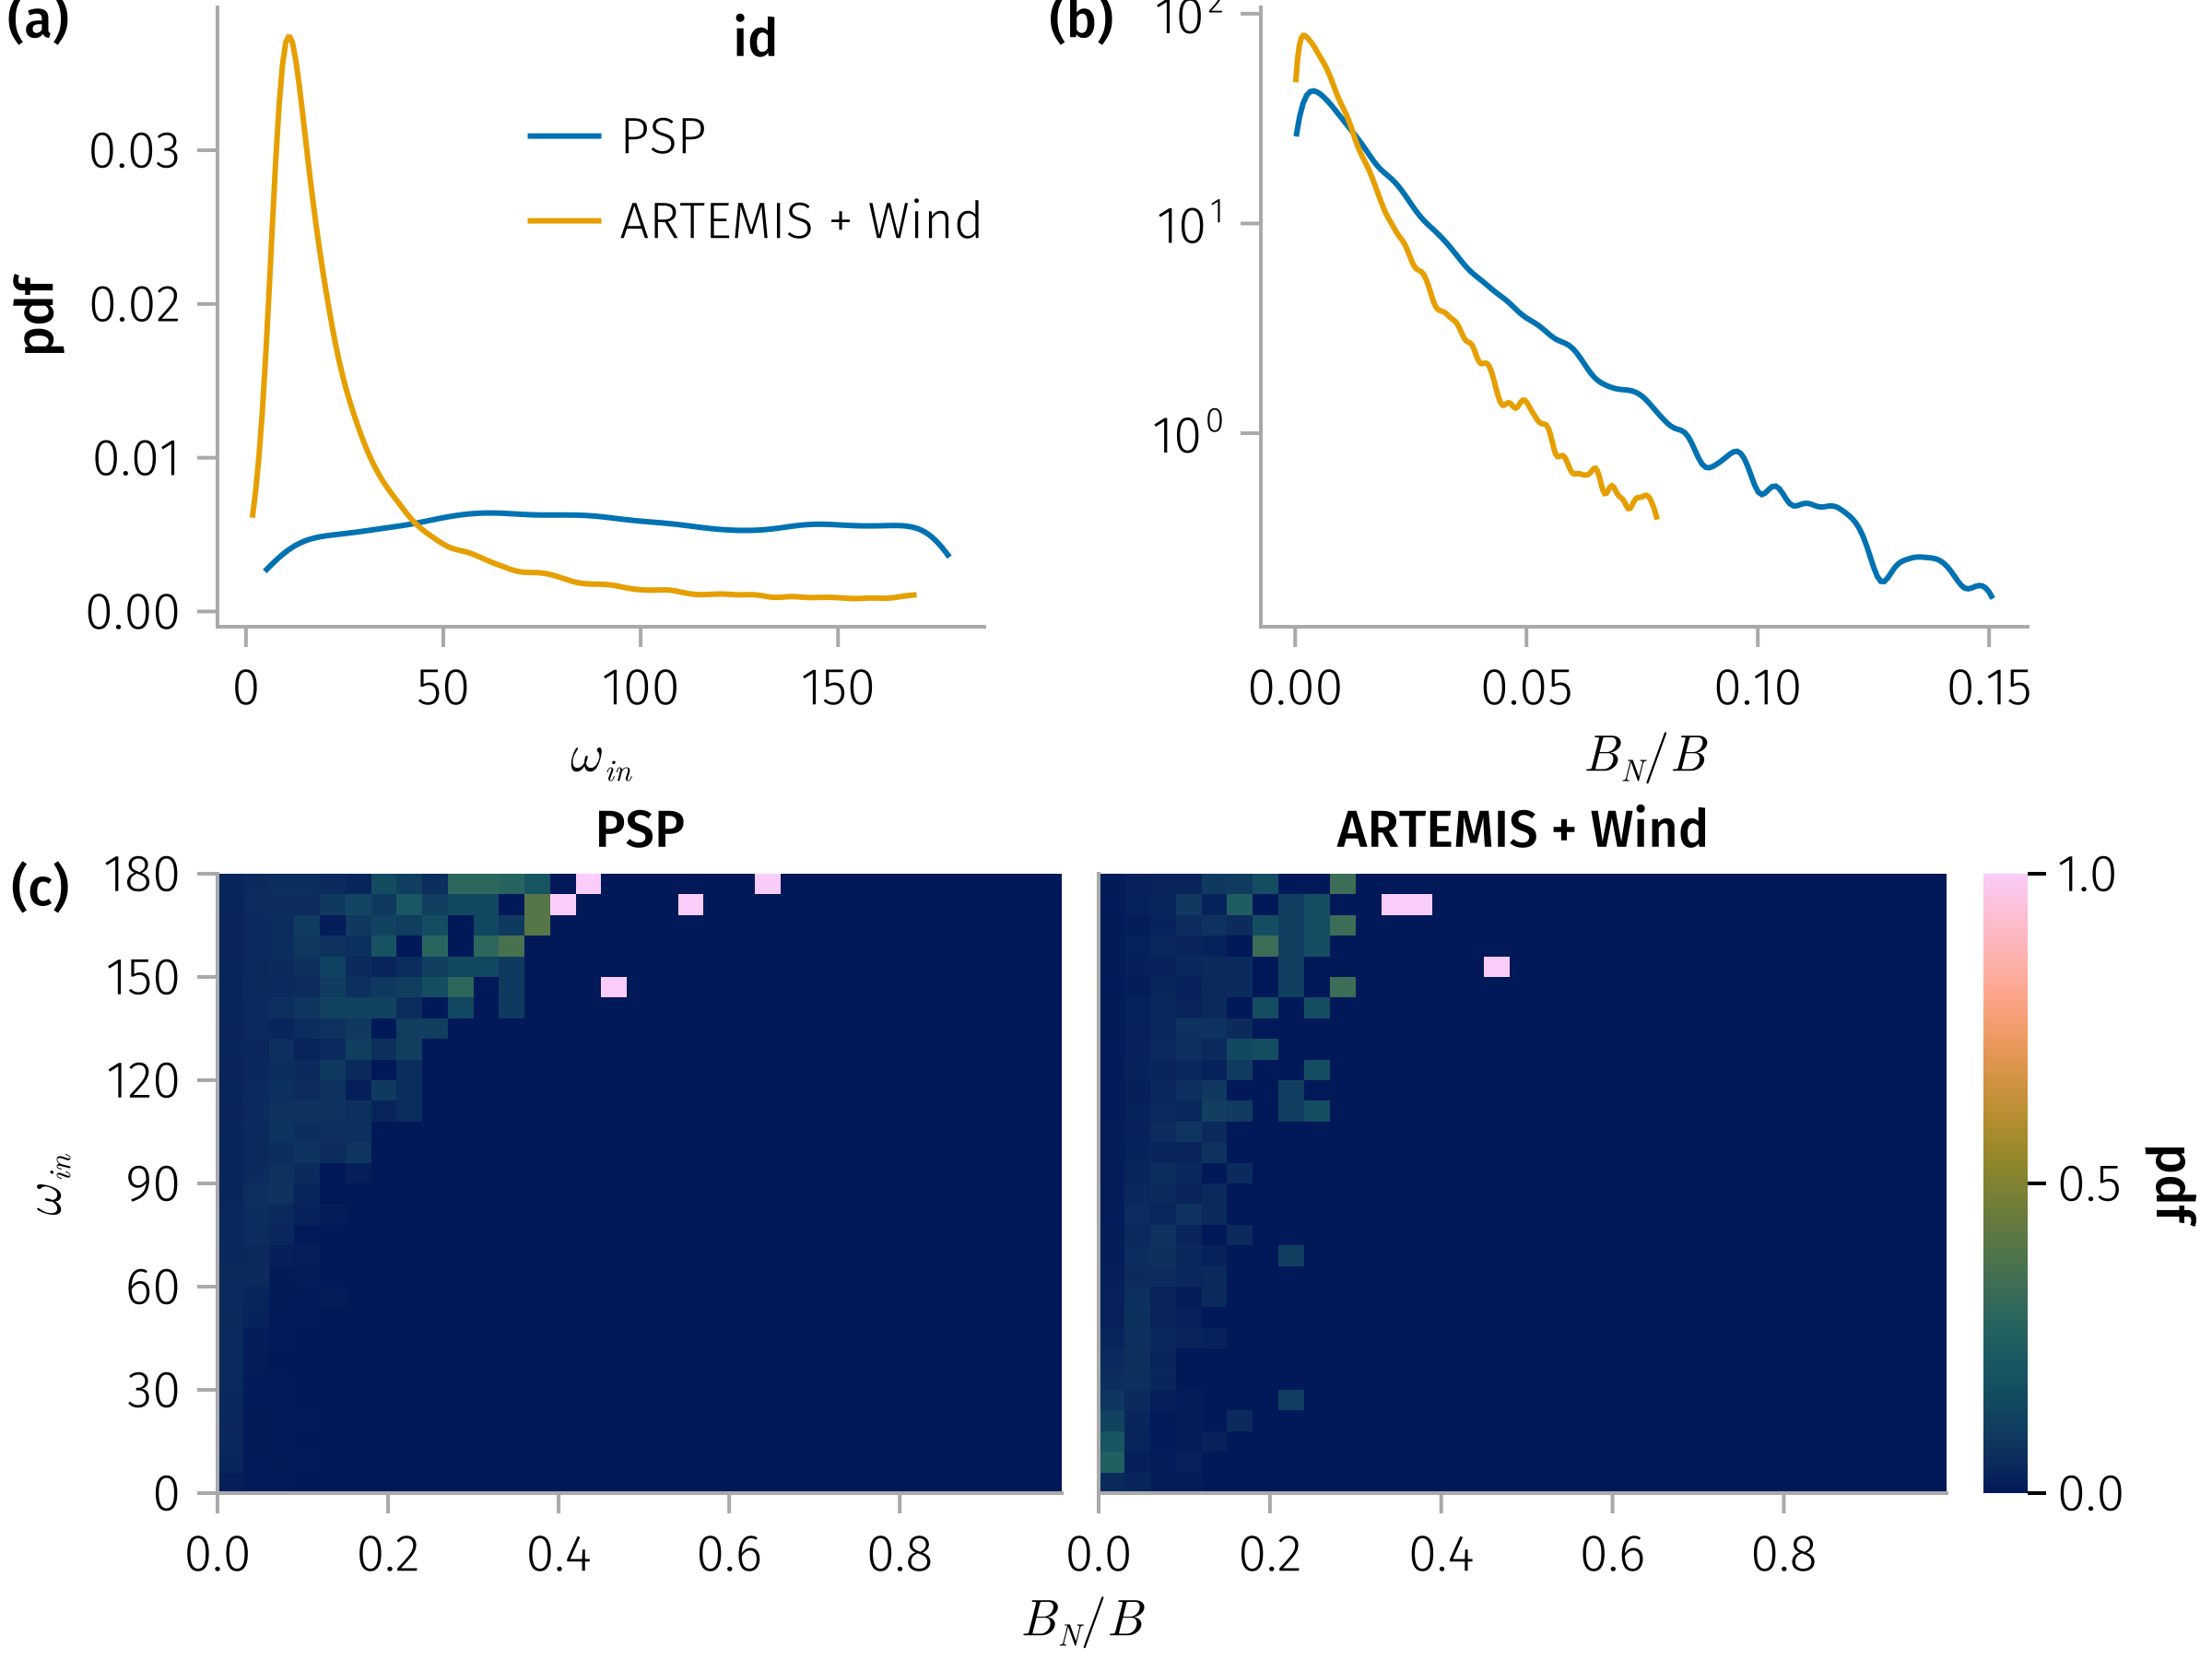

In [0]:
for 𝐧 in [:mva], subset in (true, false)
    normalization = :column
    𝒎 = var_mapping(; 𝐧)
    tdf = dropmissing(df, :B_n_mva_norm)
    tdf = subset ? subset_𝐧(tdf, 𝐧) : tdf
    plt = AoG.data(tdf) * mapping(col=:id => layout_func)
    duration_spec = plt * mapping(:duration, 𝒎.ω_in)
    f = draw(duration_spec)
    display(f)
end

### β vs A_He

There are two populations for beta and alpha particles abundance, corresponding to different sources of solubility. Correlation exist.

In [0]:
for 𝐧 in [:mva]
    view = true
    𝒎 = var_mapping(; 𝐧)

    tdf = @chain df begin
        @rsubset(all(!isnan, (:B_n_mva_norm, :Q_sonnerup, :σ_c, :ΔV_ratio, :ΔV_cosθ)); view=true)
        dropmissing([:B_n_mva_norm, :duration, :σ_c])
        @transform!(:duration = Float64.(:duration))
        subset_𝐧(𝐧)
    end

    β_A_He_df = @chain df begin
        @rsubset(all(!isnan, (:β, :A_He)); view=true)
        dropmissing([:β, :A_He])
        @transform!(:log_β = log10.(:β))
        @rsubset(:A_He < 20, :log_β > -1.5)
    end


    layout = mapping(row=:id, col=:enc)

    plt = data(tdf) * layout
    vis = visual(Scatter; markersize=6)
    fig = Figure(; size=(1200, 800))
    axis = (;)


    ΔV_cosθ_group = :ΔV_cosθ => >(0)
    ΔV_cosθ_map = mapping(group=ΔV_cosθ_group, color=ΔV_cosθ_group)

    ΔV_spec = plt * mapping(:ΔV_ratio, :ΔV_cosθ) * (vis + AoG.linear() * ΔV_cosθ_map)
    σc_σr_spec = plt * mapping(:σ_c, :σ_r) * (vis + AoG.smooth() * visual(color=:red))

    A_He_group = mapping(group=:A_He => >(1.5), color=:A_He => >(1.5))

    β_A_He_spec = data(β_A_He_df) * layout * mapping(:log_β, :A_He) * (vis + AoG.smooth(; degree=1) * A_He_group)

    draw!(fig[1, 2], ΔV_spec; axis=(; limits=((0, 2), (-1, 1),)))
    draw!(fig[2, 1], σc_σr_spec)
    draw!(fig[2, 2], β_A_He_spec)

    # pretty_legend!(fig, grid1)
    # add_labels!([ga, gb, gc])
    display(fig)
end

### Q_sonnerup and other variables

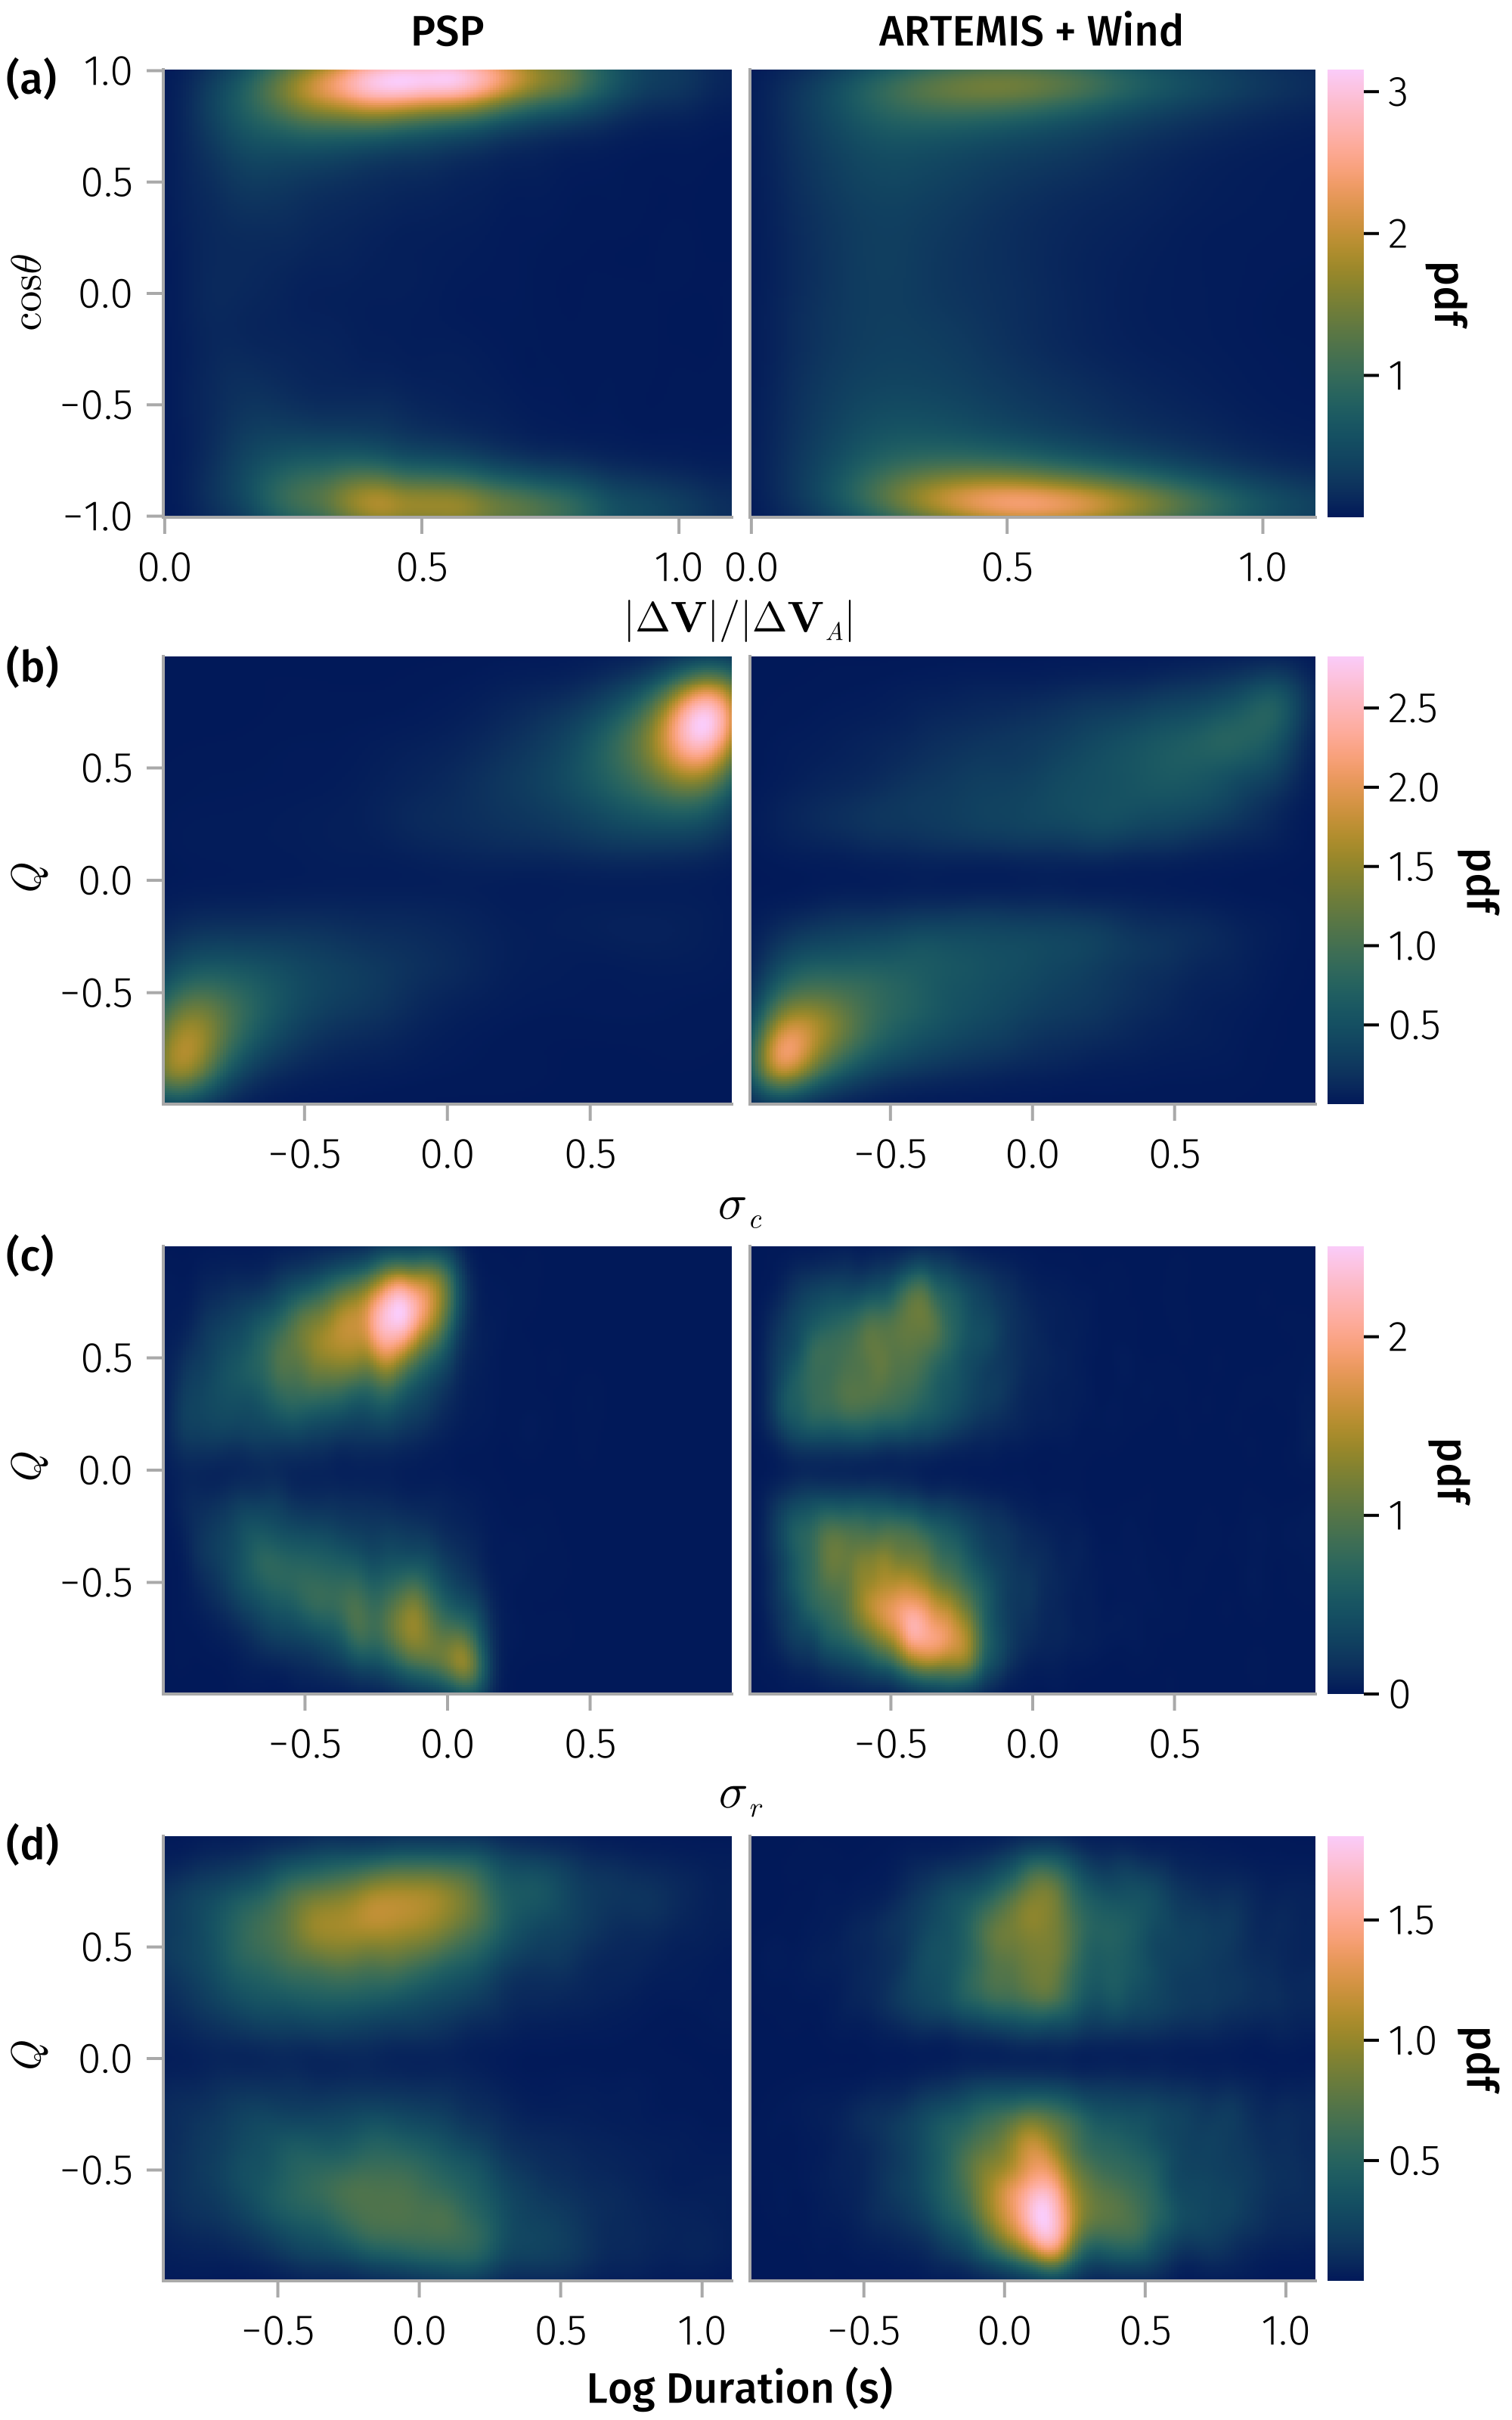

In [0]:
𝒎 = var_mapping(; 𝐧)

fig = Figure(; size=(500, 800))
let vars = [:Q_sonnerup, :duration, :σ_c]
    tdf = @chain df begin
        dropmissing(vars)
        @rsubset(all(!isnan, (:ΔV_cosθ, :Q_sonnerup, :σ_c)); view=true)
    end
    plt = AoG.data(tdf) * mapping(col=:id => layout_func)

    Q_limit = (-0.992, 0.992) # mainly for plotting so not show (-1, 1) in ticks
    ΔV_spec = plt * mapping(𝒎.ΔV_ratio, 𝒎.ΔV_cosθ) * AoG.density(; datalimits=((0, 1.1), (-1, 1)))
    # duration_Q_spec = plt * mapping(:duration, 𝒎.Q) * AoG.density(; datalimits=((0, 3.1), Q_limit))
    duration_Q_spec = plt * mapping(:duration => log10 => "Log Duration (s)", 𝒎.Q) * AoG.density(; datalimits=((-0.9, 1.1), Q_limit))
    # duration_Q_spec = plt * mapping(:duration => log10, 𝒎.Q) * fhist(; binedges=(-0.9:0.1:1.1, -0.99:0.1:0.99), normalization=:column)
    σc_Q_spec = plt * mapping(:σ_c => L"σ_c", 𝒎.Q) * AoG.density()
    σr_Q_spec = plt * mapping(:σ_r => L"σ_r", 𝒎.Q) * AoG.density(; datalimits=(Q_limit, Q_limit))

    ff11, ff12, ff21, ff22 = fig[1, 1], fig[2, 1], fig[3, 1], fig[4, 1]
    grid1 = cdraw!(ff11, ΔV_spec)
    grid3 = cdraw!(ff12, σc_Q_spec)
    grid4 = cdraw!(ff21, σr_Q_spec)
    grid2 = cdraw!(ff22, duration_Q_spec)

    for f in (ff11, ff12, ff21, ff22)
        colgap!(Makie.content(f[1, 1]), 6)
    end

    rowgap!(fig.layout, 4)
    for g in (grid3, grid4)
        ax = g[1].axis
        ax.xlabelpadding[] = 1
        ax.xlabelsize[] = 16
    end
    add_labels!([fig[1, 1], fig[2, 1], fig[3, 1], fig[4, 1]]; position=Left(), padding=(0, 0, 0, -5))
    hide_facet_labels!.((grid2, grid3, grid4))
    easy_save("Q_sonnerup_joint_dist_den"; force=true)
end

#### Q_sonnerup vs B_n

Two populations for Q_sonnerup vs B_n: large B_n has larger Q_sonnerup. No strong correlation for small B_n groups.

In [0]:
let 𝐧 = :mva
    𝒎 = var_mapping(; 𝐧)
    Bn_df = @chain df begin
        @rsubset(all(isfinite, (:B_n_mva_norm, :Q_sonnerup)); view=true)
        subset_𝐧(𝐧)
    end
    Bn_Q_spec = data(Bn_df) * mapping(𝒎.bn, :Q_sonnerup => L"Q", col=:id => layout_func) * AoG.density()
    draw(Bn_Q_spec)
end

#### Q_sonnerup vs A_He

We observe very weak correlation for PSP when $A_{He}<1$, and no correlation for Wind. 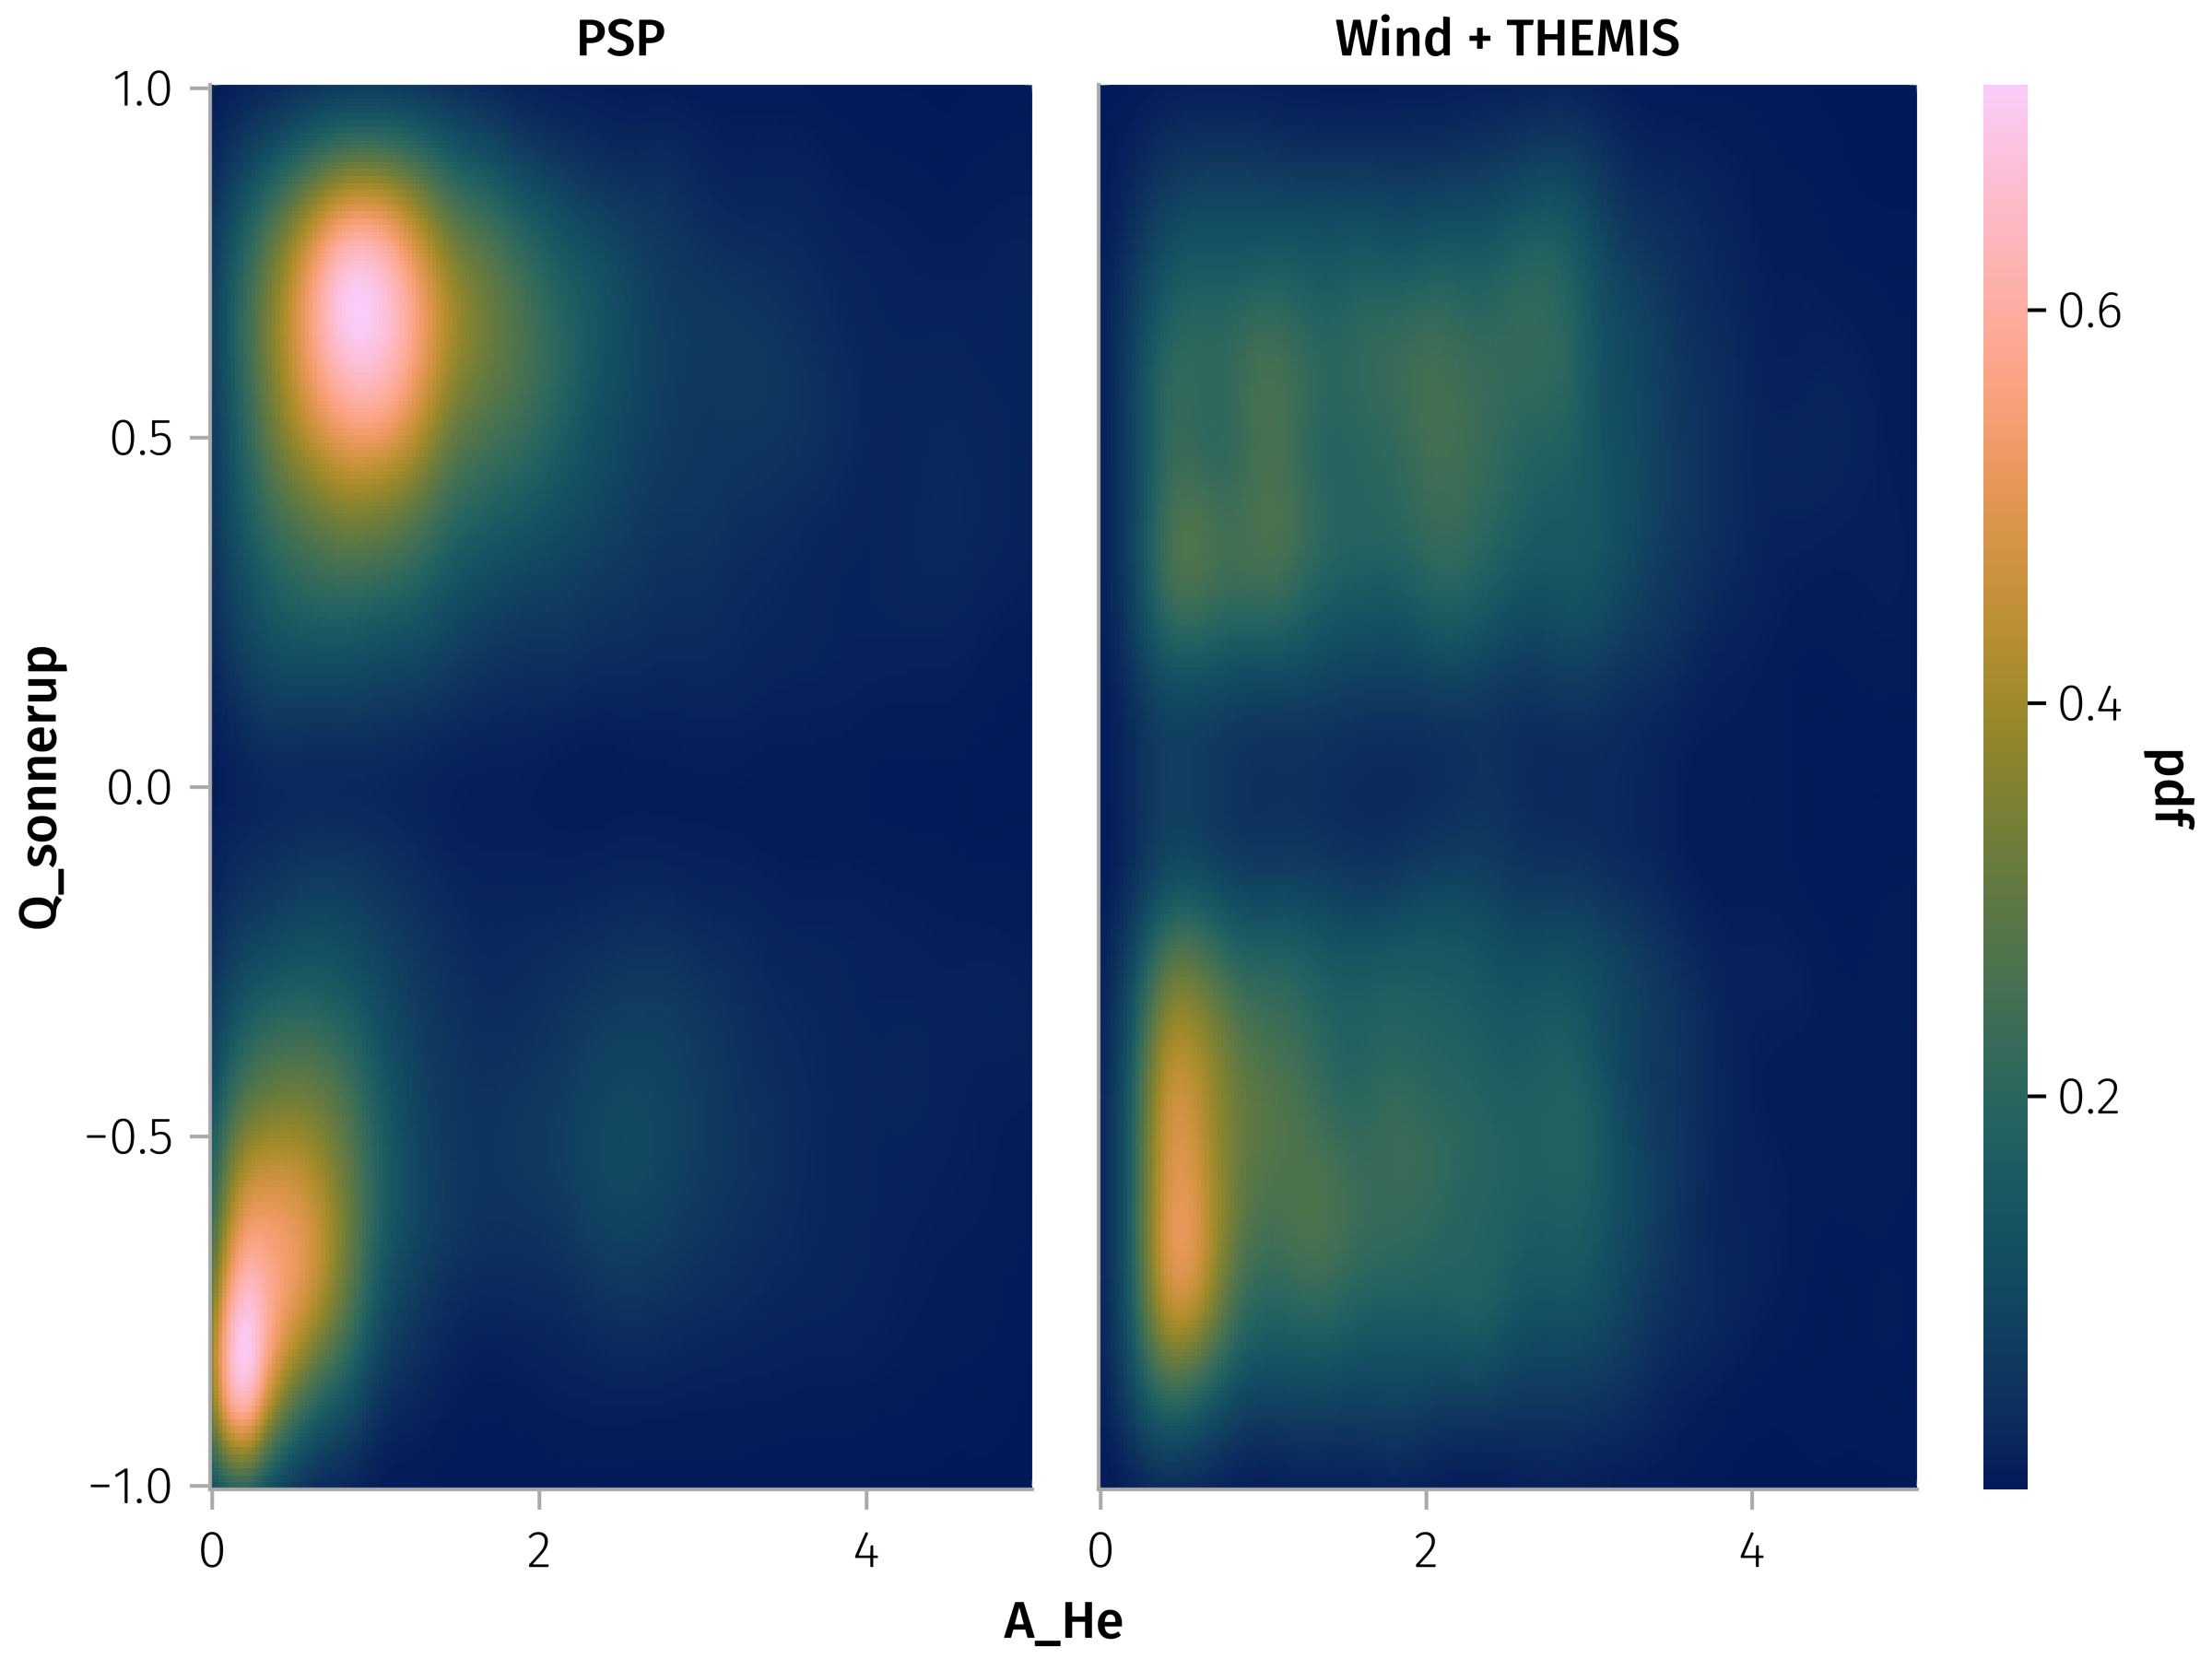

In [0]:
let
    𝒎 = var_mapping()
    A_He_df = @rsubset(df, :A_He > 0, isfinite(:Q_sonnerup))
    A_He_Q_spec = data(A_He_df) * mapping(:A_He, :Q_sonnerup, col=:id => layout_func) * AoG.density(; datalimits=((0, 5), (-1, 1)))
    draw(A_He_Q_spec)
    easy_save("A_He_Q_sonnerup")
end

#### Q_sonnerup vs β

No obvious correlation for PSP and Wind 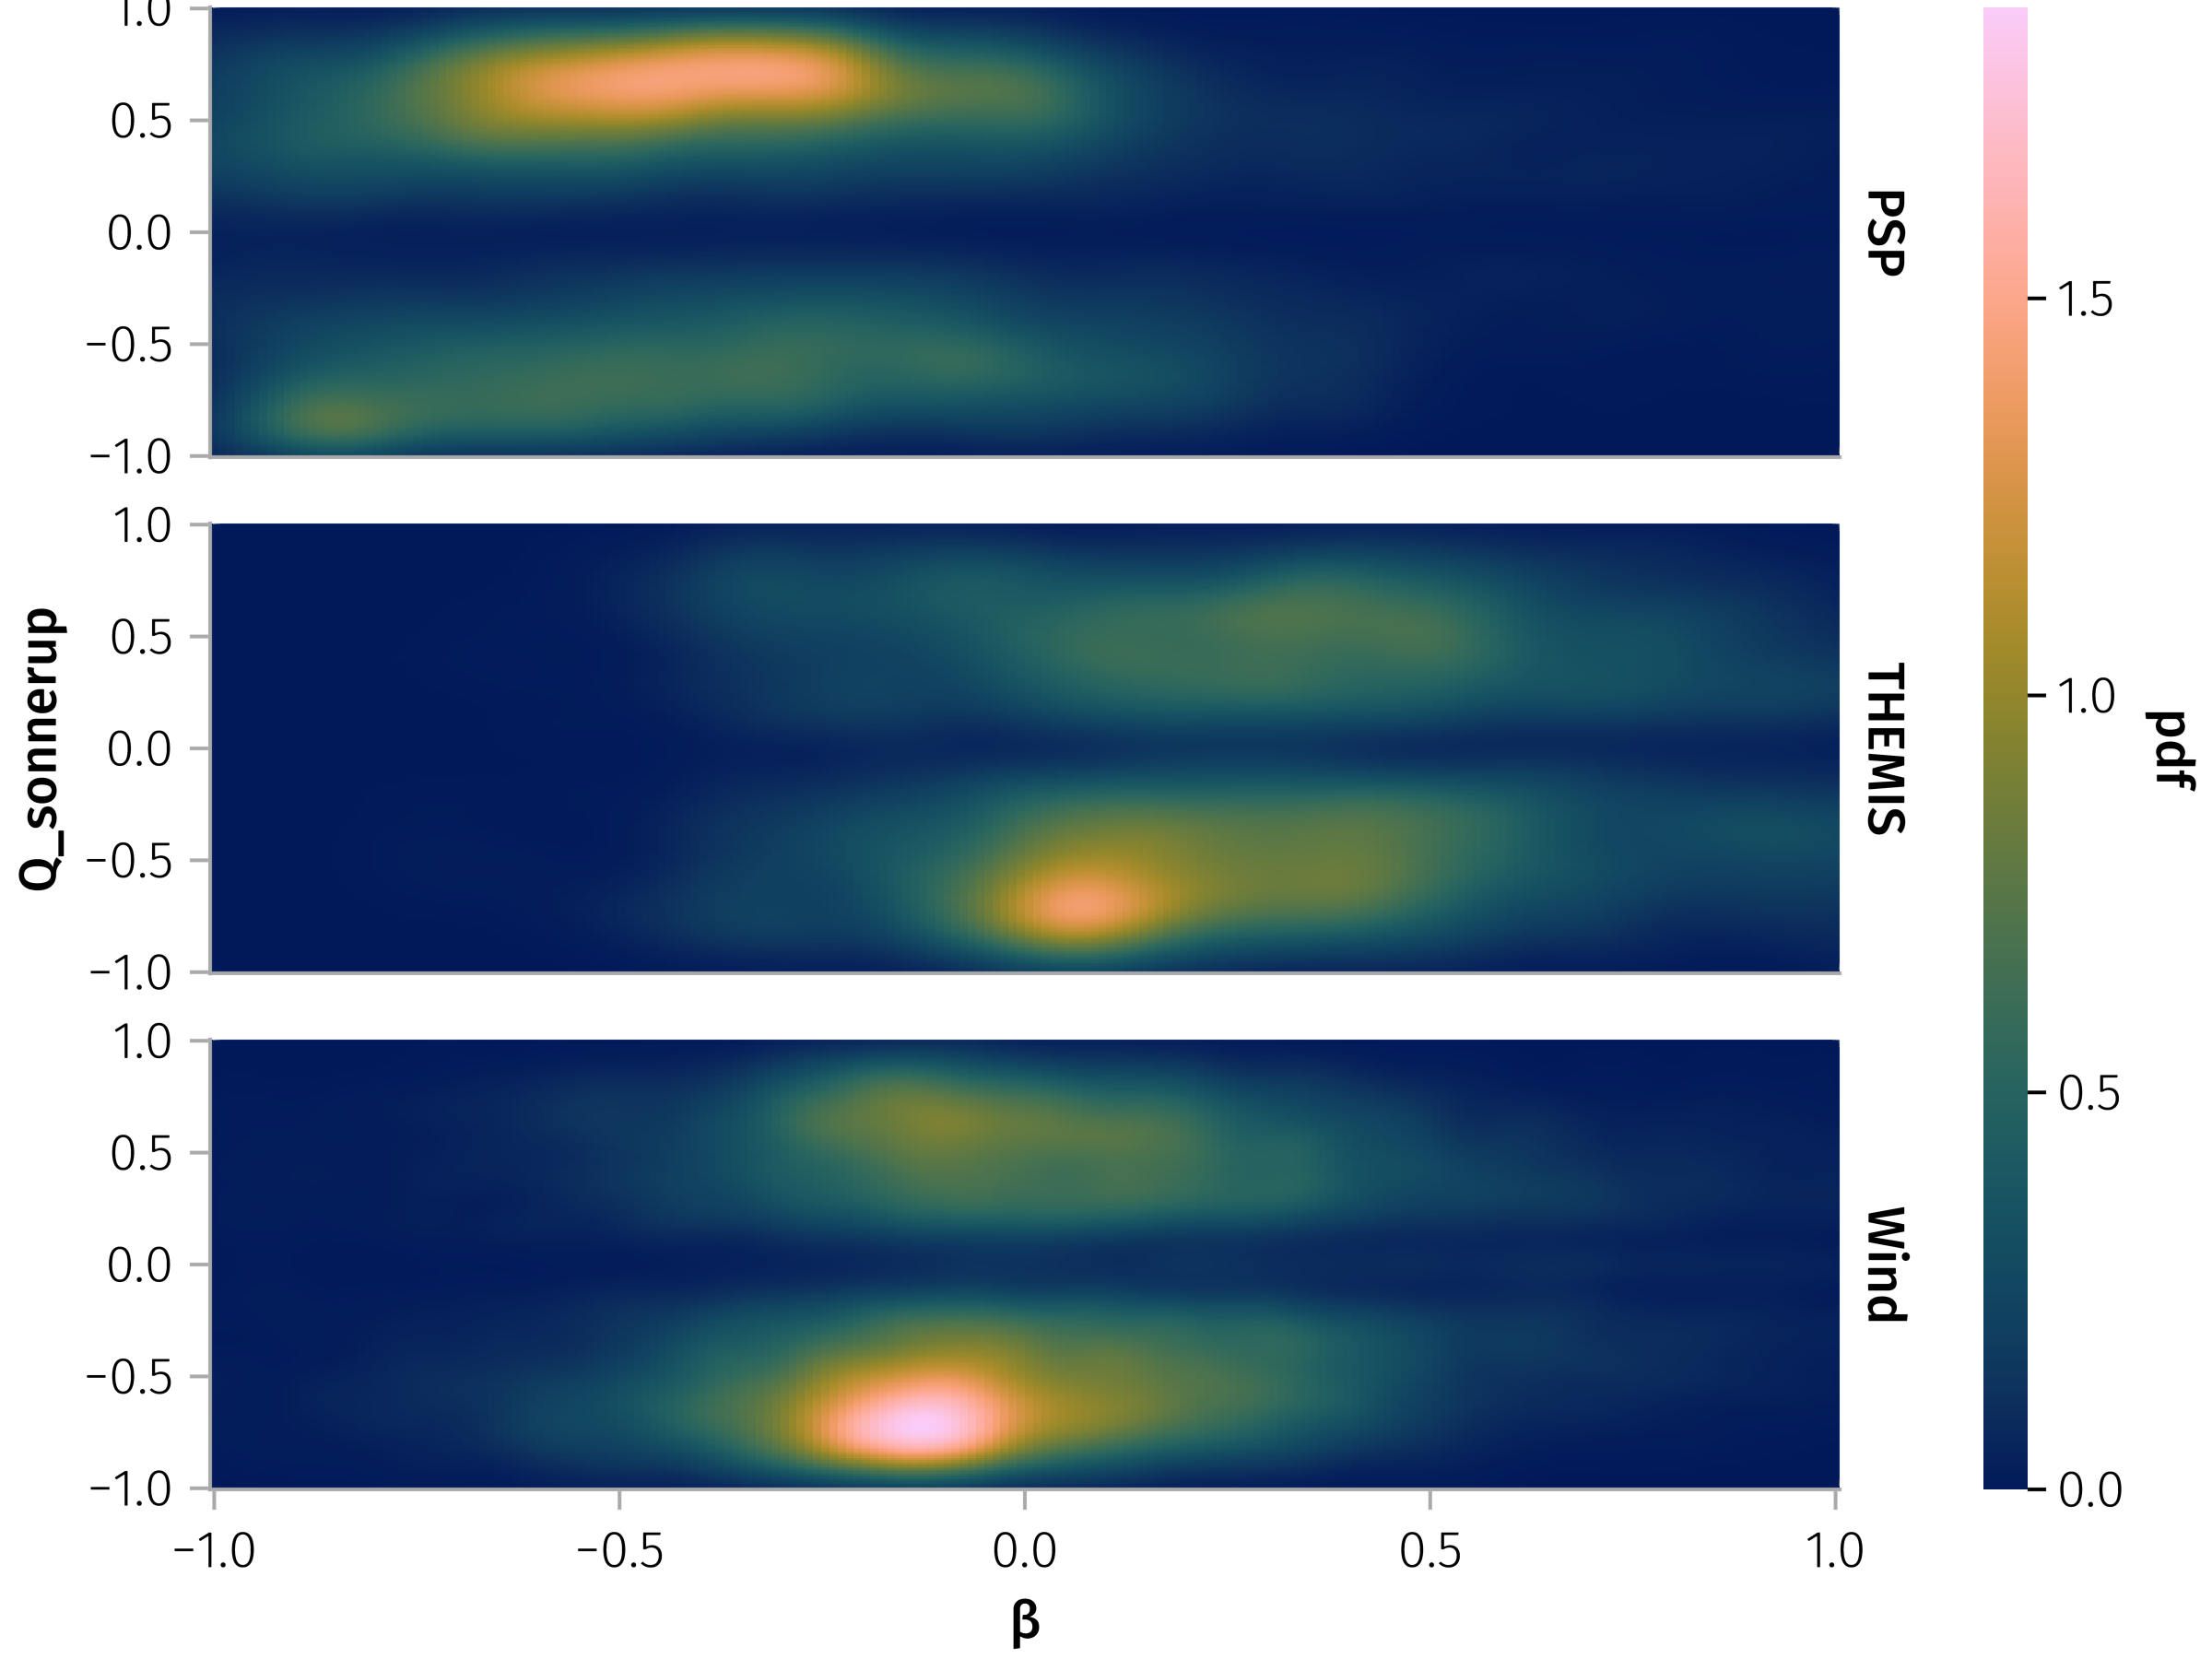.

In [0]:
let
    β_df = @rsubset(df, all(isfinite, (:β, :Q_sonnerup)); view=true)
    layout = mapping(row=:id)
    β_Q_spec = data(β_df) * mapping(:β => log10, :Q_sonnerup) * layout * AoG.density(; datalimits=((-1, 1), (-1, 1)))
    draw(β_Q_spec)
    easy_save("β_Q_sonnerup")
end

## Duration vs Alfvénicity Correlation

Let’s analyze the relationship between duration and Alfvénicity to see if they are correlated.

In [0]:
using HypothesisTests
using NaNStatistics
using PairPlots

# Filter for clean data with both duration and Alfvénicity measures
vars = [:duration, :Q_sonnerup, :V_l_ratio, :B_n_mva_norm]

df_corr = @chain df begin
    filter_low_mva_quality()
    dropmissing(vars)
    @transform!(:duration = Float64.(ustrip.(:duration .|> u"s")))
    @rsubset(all(!isnan, (:Q_sonnerup, :V_l_ratio, :duration, :σ_c)))
end

# Overall correlation matrix
println("Overall correlation matrix:")
cor_vars = [:Q_sonnerup, :duration, :B_n_mva_norm, :σ_c, :σ_r, :L_n_mva_norm, :J_m_max_mva_norm]
_cor_func = df -> nancor(Matrix(df[!, cor_vars]))
overall_corr = _cor_func(df_corr)
display(overall_corr)
# # Statistical significance tests
# test_q = CorrelationTest(df_corr.duration_s, df_corr.Q_sonnerup)
# test_vl = CorrelationTest(df_corr.duration_s, collect(skipmissing(df_corr.V_l_ratio)))

# println("Statistical significance:")
# println("Duration vs Q_sonnerup: p-value = $(round(pvalue(test_q), digits=6))")
# println("Duration vs V_l_ratio: p-value = $(round(pvalue(test_vl), digits=6))")

Correlation Strength:
- Duration vs Q_sonnerup: r = -0.0253 (very weak negative correlation)
- Duration vs V_l_ratio: r = -0.0134 (very weak negative correlation)

Statistical Significance:
- Duration vs Q_sonnerup: p = 0.009 (statistically significant, p \< 0.05)
- Duration vs V_l_ratio: p = 0.166 (not statistically significant, p \> 0.05)

Interpretation:
1. There is a very weak negative correlation between duration and Alfvénicity - meaning longer events tend to be slightly less Alfvénic
2. The effect size is tiny (correlations ~-0.02 to -0.03) - practically negligible

Conclusion: While there’s a statistically significant but extremely weak tendency for longer-duration current sheets to be slightly less Alfvénic, the correlation is so small it’s essentially negligible in practical terms. Duration and Alfvénicity are largely independent of each other in this dataset.

## Unused Code

In [0]:
# Visualization: Scatter plot with trend line
f_corr = Figure(size=(1400, 600))

attrs = (alpha=0.6, markersize=6)

# Duration vs Q_sonnerup
ax1 = Axis(f_corr[1, 1],
    xscale=log10,
    xlabel="Duration (seconds)",
    ylabel="Q_sonnerup (Alfvénicity)",
    title="Duration vs Alfvénicity")

scatter!(ax1, df_corr.duration_s, abs.(df_corr.Q_sonnerup); color=:blue, attrs...)

# Add trend line (remove any remaining NaNs)
valid_idx = .!isnan.(df_corr.duration_s) .& .!isnan.(df_corr.Q_sonnerup)
if sum(valid_idx) > 0
    x_valid = df_corr.duration_s[valid_idx]
    y_valid = abs.(df_corr.Q_sonnerup[valid_idx])
    x_range = range(minimum(x_valid), maximum(x_valid), length=100)
    X = hcat(ones(length(x_valid)), x_valid)
    β = X \ y_valid
    trend_y = β[1] .+ β[2] .* x_range
    lines!(ax1, x_range, trend_y, color=:red, linewidth=2, linestyle=:dash)
end

# text!(ax1, 0.05, 0.95, "r = $(round(corr_duration_q, digits=4))", space=:relative, fontsize=12, color=:black)

# Duration vs V_l_ratio  
df_vl = dropmissing(df_corr, :V_l_ratio)
ax2 = Axis(f_corr[1, 2],
    xscale=log10,
    xlabel="Duration (seconds)",
    ylabel="V_l_ratio",
    title="Duration vs Velocity Ratio")

scatter!(ax2, df_vl.duration_s, df_vl.V_l_ratio,
    color=:green, alpha=0.6, markersize=6)

# Add trend line for V_l_ratio (remove any remaining NaNs)
valid_idx2 = .!isnan.(df_vl.duration_s) .& .!isnan.(df_vl.V_l_ratio)
if sum(valid_idx2) > 0
    x_valid2 = df_vl.duration_s[valid_idx2]
    y_valid2 = df_vl.V_l_ratio[valid_idx2]
    x_range2 = range(minimum(x_valid2), maximum(x_valid2), length=100)
    X2 = hcat(ones(length(x_valid2)), x_valid2)
    β2 = X2 \ y_valid2
    trend_y2 = β2[1] .+ β2[2] .* x_range2
    lines!(ax2, x_range2, trend_y2, color=:red, linewidth=2, linestyle=:dash)
end
ylims!(ax2, 0, 1)
# text!(ax2, 0.05, 0.95, "r = $(round(corr_duration_vl, digits=4))", space=:relative, fontsize=12, color=:black)

f_corr

In [0]:
using CategoricalArrays
using NaNStatistics
# Binned analysis
duration_bins = [0, 2, 5, 10, 20, 50, maximum(df_corr.duration_s)]
df_binned = @transform(df_corr,
    :duration_bin = cut(:duration_s, duration_bins, labels=["0-2s", "2-5s", "5-10s", "10-20s", "20-50s", ">50s"]))

binned_stats = @chain df_binned begin
    dropmissing([:Q_sonnerup, :V_l_ratio])
    groupby(:duration_bin)
    @combine(
        :count = length(:duration_s),
        :mean_duration = nanmean(:duration_s),
        :mean_Q_sonnerup = nanmean(abs.(:Q_sonnerup)),
        :std_Q_sonnerup = nanstd(abs.(:Q_sonnerup)),
        :mean_V_l_ratio = nanmean(:V_l_ratio),
        :std_V_l_ratio = nanstd(:V_l_ratio)
    )
end

println("Mean Alfvénicity by Duration Bins:")
select(binned_stats, :duration_bin, :count, :mean_Q_sonnerup, :mean_V_l_ratio)

In [0]:
# Add binned averages to the scatter plots
for (i, row) in enumerate(eachrow(binned_stats))
    if i < nrow(binned_stats)
        # Get bin boundaries
        bin_start = duration_bins[i]
        bin_end = duration_bins[i+1]
        bin_center = (bin_start + bin_end) / 2

        # Add mean points with error bars to Q_sonnerup plot
        scatter!(ax1, [bin_center], [row.mean_Q_sonnerup],
            color=:red, markersize=12, marker=:diamond)
        errorbars!(ax1, [bin_center], [row.mean_Q_sonnerup], [row.std_Q_sonnerup],
            color=:red, whiskerwidth=8, linewidth=2)

        # Add mean points with error bars to V_l_ratio plot  
        scatter!(ax2, [bin_center], [row.mean_V_l_ratio],
            color=:red, markersize=12, marker=:diamond)
        errorbars!(ax2, [bin_center], [row.mean_V_l_ratio], [row.std_V_l_ratio],
            color=:red, whiskerwidth=8, linewidth=2)
    else
        # Handle the last bin (>50s) - use a representative position
        bin_center = 60  # Approximate position for >50s bin

        scatter!(ax1, [bin_center], [row.mean_Q_sonnerup],
            color=:red, markersize=12, marker=:diamond)
        errorbars!(ax1, [bin_center], [row.mean_Q_sonnerup], [row.std_Q_sonnerup],
            color=:red, whiskerwidth=8, linewidth=2)

        scatter!(ax2, [bin_center], [row.mean_V_l_ratio],
            color=:red, markersize=12, marker=:diamond)
        errorbars!(ax2, [bin_center], [row.mean_V_l_ratio], [row.std_V_l_ratio],
            color=:red, whiskerwidth=8, linewidth=2)
    end
end

# Add legend explaining the red diamonds
Legend(f_corr[2, :], [MarkerElement(color=:red, marker=:diamond, markersize=12)],
    ["Binned Averages ± Std"], orientation=:horizontal, tellwidth=false, tellheight=true)

f_corr